# OTUS |  $ p p > t \bar{t} $ 

This notebooks applies OTUS to our second test case: semi-leptonic $t \bar{t}$ decay.

Our physical latent-space is the $e^-$, $\bar{\nu}_e$, $b$, $\bar{b}$, $u$, $\bar{d}$ 4-momentum information produced by the program MadGraph.

Our data-space data is the $e^+$, $MET$, $jet1$, $jet2$, $jet3$, $jet4$ 4-momentum information produced by the program Delphes. The jets are ordered in descending $p_T$.

We arrange this information into 24 dimensional vectors

- Latent space (z): [$p^{\mu}_{e-}$,$p^{\mu}_{\bar{\nu}_e}$,$p^{\mu}_{b}$,$p^{\mu}_{\bar{b}}$,$p^{\mu}_{u}$,$p^{\mu}_{\bar{d}}$]
- Data space (x): [$p^{\mu}_{e^-}$,$p^{\mu}_{MET}$,$p^{\mu}_{jet1}$,$p^{\mu}_{jet2}$,$p^{\mu}_{jet3}$,$p^{\mu}_{jet4}$]

where $p^{\mu}=[p_x, p_y, p_z, E]$ is the 4-momentum of the given particle.

###### Additional Losses and Constraints:
We impose the following additional losses and constraints in this problem.

As in the $p p > Z > e^+ e^-$ test case, we explicitly enforce the Minkowski metric in the output of the networks. Namely, the networks predict the 3-momenta ($\vec{p}$) of the particles. Energy information is then restored using the Minkowski metric: $E^2 = |\vec{p}|^2 + m^2$.

We also explicitly enforce the lower $p_T$ threshold on jets, which requires that $p_T>20$ GeV. Only samples generated by the decoder which pass this threshold are used to calculate losses. This requires modifying the data-space loss term slightly. Additionally, to help with stable traiing, we choose a ResNet architecture for both our encoder and decoder networks.

See the paper for more details: https://arxiv.org/abs/2101.08944.

# Load Required Libraries

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

#-- Add utilityFunctions/ to easily use utility .py files --#
import sys
sys.path.append("../../utilityFunctions/")

#-- Determine if using GPU or CPU --#
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Set to '-1' to disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '5' # Set to '-1' to disable GPU
from configs import device, data_dims

print('Using device:', device)

Using device: cuda


# Meta Parameters

In [2]:
data_directory    = '../../data/'
dataset_name      = 'ppttbar'

#-- Set random seeds --#
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

#-- Raw or standardized inputs/outputs --#
# If True, model inputs/outputs should be in the "raw" (unstandardized) space
raw_io = True  

#-- Set data type --#
from configs import float_type
print('Using data type: ', float_type)

Using data type:  float32


# Load Data

In [3]:
from func_utils import get_dataset, standardize
from torch.utils.data import DataLoader

#-- Get training and validation dataset --#
dataset = get_dataset(dataset_name, data_dir=data_directory)
z_data, x_data = dataset['z_data'], dataset['x_data']
print("Data total shapes: ",z_data.shape, x_data.shape)

x_dim = int(x_data.shape[1])
z_dim = int(z_data.shape[1])

#-- Split into training and validation sets --#
train_size = 222761
val_size = 40000  # Validation set used to evaluate/tune models

x_train = x_data[:train_size, :]
x_val = x_data[train_size:train_size+val_size, :]

z_train = z_data[:train_size, :]
z_val = z_data[train_size:train_size+val_size, :]

#-- Convert data to proper type --#
x_train, x_val, z_train, z_val = list(map(lambda x: x.astype(float_type), [x_train, x_val, z_train, z_val]))

#-- Obtain mean and std information --#
# This is needed to standardize/unstandardize data
x_train_mean, x_train_std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
z_train_mean, z_train_std = np.mean(z_train, axis=0), np.std(z_train, axis=0)

# If raw_io == False, then standardize the data with training set statistics
if not raw_io:
    x_train = (x_train - x_train_mean) / x_train_std  
    x_val = (x_val - x_train_mean) / x_train_std  
if not raw_io:
    z_train = (z_train - z_train_mean) / z_train_std
    z_val = (z_val - z_train_mean) / z_train_std

#-- Set evaluation parameters --#
eval_batch_size = 20000  # Always use high batch size on validation set to accurately assess performance
eval_loaders = DataLoader(dataset=x_val, batch_size=eval_batch_size, shuffle=True), \
               DataLoader(dataset=z_val, batch_size=eval_batch_size, shuffle=True)

print("z_train shape, x_train shape: ", z_train.shape, x_train.shape)
print("z_val   shape, x_val   shape: ", z_val.shape, x_val.shape)

Data total shapes:  (262761, 24) (262761, 24)
z_train shape, x_train shape:  (222761, 24) (222761, 24)
z_val   shape, x_val   shape:  (40000, 24) (40000, 24)


### Define target invariant masses (for both training and validation data)

Invariant mass relation: $m^2 = E^2 - |\vec{p}|^2$. For objects with ill-defined mass (MET and Jets) we fix $m=0$.

In [4]:
x_inv_masses = np.zeros(6)
z_inv_masses = np.array([0., 0., 4.7, 4.7, 0., 0.])

# Train

## Import Training Specific Libraries and Functions

In [5]:
import torch
from torch import optim
import torch.nn as nn
from ppttbar_constraints import threshold_check
from ppttbar_utils import train_and_val

## Define Meta Network Parameters

In [6]:
from models import Autoencoder, StochasticResNet

## Define Model and Hyperparameters

###### Latent loss function:
Finite sample approximation of Sliced Wasserstein Distance (SWD) between $p(z)$ and $p_E(z) = \int_x p(x) p_E(z|x)$

- $L_{latent}(Z, \tilde{Z}) = \frac{1}{L * M} \sum_{l=1}^{L} \sum_{m=1}^{M} c((\theta_l \cdot z_m)_{sorted}, (\theta_l \cdot \tilde{z}_m)_{sorted})$

where $c(\cdot, \cdot) = |\cdot - \cdot|^2$

###### Data loss function:
- $L_{data}(X, \tilde{X}) = \frac{1}{M} \sum_{m=1}^M [\frac{1_S(\tilde{x}_m)}{p_D(S)} 
c(x_m,  \tilde{x}_m)]$

where $c(\cdot, \cdot) = |\cdot - \cdot|^2$; $1_S(x)$ is the indicator function of $S$ so that it equals $1$ if $x \in S$, and $0$ otherwise, and $p_D(S) := \int dt p_D(t) 1_S(t)$ normalizes this distribution.

###### Full loss function:
- $L_{tot} = \beta L_{data}(X, \tilde{X}) + \lambda L_{latent}(Z, \tilde{Z})$ 

###### Core Hyperparameters
The hyperparameter definitions are as follows:

- num_hidden_layers: The number of hidden layers in both the encoder and decoder networks
- dim_per_hidden_layer: The dimensions per hidden layer in both the encoder and decoder networks
- lr: The learning rate of the networks
- lamb: The $\lambda$ coefficient in front of the latent loss term
- num_slices: Number of random projections used for computing SWD
- epochs: The number of epochs used during training

Hyperparameters for other losses that were tried, but use during main training is currently discouraged:

- tau: Coefficient in front of the alternate data-space loss ("alt_x_loss"), which is the SWD between $p(x)$ and $p_D(x):=\int_z p(z) p_D(x|z)$
- rho: Coefficient in front of an additional decoder constraint loss (based on soft-penalty approach to learning hard thresholds/ttbar_constraints)

###### Joint Training Hyperparameters
- beta: Coefficient in front of data loss, $L_{data}$ 
- beta_e: Coefficient in front of the encoder "anchor loss" 
- beta_d: Coefficient in front of the decoder "anchor loss" 

In [7]:
# Note: most of the unspecified hyperparameters are set to 0 by default

# common configs
config = {
    'lr': 0.001,
    'lamb': 20.,  # coefficient in front of latent loss, SWD between p(z) and Q(z):=\int_x p(x) Q(z|x)
    'tau': 0,  # coefficient in front of "alt_x_loss", which is the SWD between p(x) and p_G(x):=\int_z p(z) p_G(x|z);
               # this loss is not part of the original WAE formulation and is not used.
    'rho': 0, # coef in front of decoder constraint loss (based on soft-penalty approach to learning hard thresholds/ttbar_constraints)
    'nu_e': 0,  # coefficient in front of encoder "anchor loss"
    'nu_d': 0,
}

joint_step_config = {
    'beta': 1.,  # coefficient in front of data loss, E[c(x, x reconstructed)], where c is typically the 2-norm.
}

encoder_step_config = {
    'beta': 0.,
}


hidden_layer_dims = [64, 64]
activation = torch.nn.ReLU
from models import Autoencoder, StochasticResNet
model = Autoencoder(x_dim, z_dim, ConditionalModel=StochasticResNet, encoder_hidden_layer_dims=hidden_layer_dims,
                    stoch_enc=True, stoch_dec=True, activation=activation, raw_io=raw_io,
                    x_inv_masses=x_inv_masses, x_stats=np.stack([x_train_mean, x_train_std]),
                    z_inv_masses=z_inv_masses, z_stats=np.stack([z_train_mean, z_train_std]),
                    # ResNet settings:
                    io_residual=True,
                    res_mlp_depth=2
                            )

In [8]:
# Print model 
model

Autoencoder(
  (encoder): StochasticResNet(
    (nn): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): ResBlock(
        (module): Sequential(
          (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (2): Linear(in_features=64, out_features=18, bias=True)
    )
  )
  (decoder): StochasticResNet(
    (nn): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): ResBlock(
        (module): Sequential(
          (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): B

In [9]:
train_batch_size = 20000
train_loaders = DataLoader(dataset=x_train, batch_size=train_batch_size, shuffle=True), \
                DataLoader(dataset=z_train, batch_size=train_batch_size, shuffle=True)

# Note that the Z and X data loaders are both shuffled, so (z, x) samples no longer match up (unlike in the source
# data arrays), as is demanded by our unsupervised problem setup.

## Training Stage 1

Perform a joint training strategy (encoder and decoder simultaneously). This strategy of joint training is the vanilla SWAE approach.

In [10]:
%%time

config.update(**joint_step_config)

config['epochs'] = 1000

optimizer = optim.Adam(model.parameters(), lr=config["lr"])

history = {}
log_freq = 100
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, config, optimizer, verbose=True, prev_hist=history, log_freq=log_freq)

{'lr': 0.001, 'lamb': 20.0, 'tau': 0, 'rho': 0, 'nu_e': 0, 'nu_d': 0, 'beta': 1.0, 'epochs': 1000}
epoch:	0
train -- loss:496039, prate:0.673, x_loss:8317.56, z_loss:24386.1, anchor_loss:0
eval -- loss:68392.6, prate:0.67, x_loss:6095.23, z_loss:30203.5, alt_x_loss:38189.1, anchor_loss:0.507915
epoch:	100
train -- loss:3549.12, prate:0.693, x_loss:168.937, z_loss:169.009, anchor_loss:0
eval -- loss:470.77, prate:0.684, x_loss:169.567, z_loss:60.4161, alt_x_loss:410.354, anchor_loss:0.143523
epoch:	200
train -- loss:4930.69, prate:0.664, x_loss:126.664, z_loss:240.201, anchor_loss:0
eval -- loss:473.967, prate:0.689, x_loss:163.706, z_loss:50.234, alt_x_loss:423.733, anchor_loss:0.144991
epoch:	300
train -- loss:2481.05, prate:0.669, x_loss:175.587, z_loss:115.273, anchor_loss:0
eval -- loss:487.026, prate:0.677, x_loss:103.897, z_loss:48.8007, alt_x_loss:438.225, anchor_loss:0.155296
epoch:	400
train -- loss:4351.49, prate:0.646, x_loss:94.1244, z_loss:212.868, anchor_loss:0
eval -- lo

In [11]:
# save_path = 'swae-dataset=%s-lamb=20-joint_epochs=1000.pkl' %dataset_name
# torch.save(model.state_dict(), save_path)
# print('model weights saved at', save_path)

## Training Stage 2

Finetune the decoder alone to further minimize SWD(p(x), p_D(x)), at the expense of increased data reconstruction loss.

In [12]:
# save_path = 'swae-dataset=%s-lamb=20-joint_epochs=1000.pkl' %dataset_name
# saved_model_weights = torch.load(save_path)
# model.load_state_dict(saved_model_weights)

In [13]:
decoder_finetuning_config = {
    'beta': 0,  # coefficient in front of data loss in (S)WAE objective
    'tau': 1, # coefficient in front of "alt_x_loss", which is the SWD between p(x) and p_D(x)
    'lamb': 0, # disable latent loss
    'rho': 0, # no x_constraint_loss (no longer used)
    'nu_e': 0,  # anchor loss
    'nu_d': 0,
    'lr': 0.0001,  # reduced lr for fine-tuning
    'epochs': 10,
}

# optimizer = optim.Adam(model.decoder.parameters(), lr=config["lr"])
optimizer = optim.Adam(model.decoder.parameters(), lr=decoder_finetuning_config["lr"])

history = {}
log_freq = 1
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, decoder_finetuning_config, optimizer, verbose=True, prev_hist=history, log_freq=log_freq)

{'beta': 0, 'tau': 1, 'lamb': 0, 'rho': 0, 'nu_e': 0, 'nu_d': 0, 'lr': 0.0001, 'epochs': 10}
epoch:	0
train -- loss:1416.58, prate:0.625, x_loss:0, z_loss:0, anchor_loss:0
eval -- loss:330.401, prate:0.629, x_loss:80.2679, z_loss:44.0614, alt_x_loss:286.339, anchor_loss:0.160819
epoch:	1
train -- loss:915.099, prate:0.613, x_loss:0, z_loss:0, anchor_loss:0
eval -- loss:327.927, prate:0.625, x_loss:128.732, z_loss:43.6405, alt_x_loss:284.287, anchor_loss:0.162286
epoch:	2
train -- loss:1635.47, prate:0.624, x_loss:0, z_loss:0, anchor_loss:0
eval -- loss:303.883, prate:0.621, x_loss:192.945, z_loss:43.5763, alt_x_loss:260.307, anchor_loss:0.164221
epoch:	3
train -- loss:702.958, prate:0.608, x_loss:0, z_loss:0, anchor_loss:0
eval -- loss:292.503, prate:0.619, x_loss:270.257, z_loss:47.3674, alt_x_loss:245.136, anchor_loss:0.166703
epoch:	4
train -- loss:996.455, prate:0.619, x_loss:0, z_loss:0, anchor_loss:0
eval -- loss:287.666, prate:0.615, x_loss:363.104, z_loss:43.613, alt_x_loss:244

## Plot Loss History 

History dictionary:

history = {key: [] for key in ('epoch', 'train_loss', 'train_x_loss', 'train_z_loss', 'train_alt_x_loss', 'eval_loss')}

- train_loss: Total training loss 
- train_x_loss: Data space (x-space) training loss
- train_z_loss: Latent space (z-space) training loss
- train_alt_x_loss: Alternate data space loss; use is discouraged

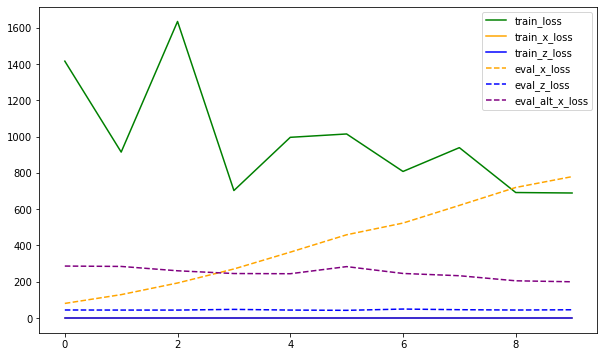

In [14]:
fig = plt.figure(figsize=(10,6))

#-- Plot training loss history --#
plt.plot(history['epoch'], history['train_loss'], color='green', label='train_loss')
plt.plot(history['epoch'], history['train_x_loss'], color='orange', label='train_x_loss')
plt.plot(history['epoch'], history['train_z_loss'], color='blue',  label='train_z_loss')
#plt.plot(history['epoch'], history['train_alt_x_loss'], color='purple', label='train_alt_x_loss')

#-- Plot evaluation loss history --#
# plt.plot(history['epoch'], history['eval_loss'], color='green', linestyle='--', label='eval_loss')
plt.plot(history['epoch'], history['eval_x_loss'], color='orange', linestyle='--', label='eval_x_loss')
plt.plot(history['epoch'], history['eval_z_loss'], color='blue', linestyle='--', label='eval_z_loss')
plt.plot(history['epoch'], history['eval_alt_x_loss'], color='purple', linestyle='--', label='eval_alt_x_loss')

plt.legend(loc='best')

# Show Results

Now that we've trained our model, it's time to inspect the results. Note that the following plots are meant to be illustrative and do not represent an exhaustive survey.

In [15]:
# Import relevant plotting functions
from plot_utils import plotFunction

## Get Results

In [16]:
# Import ttbar constraint function
from ppttbar_constraints import threshold_check

In [17]:
#-- Reset random seeds --#
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

#-- Convert model to run on CPU and run on validation data --#
model.to('cpu')
model.encoder.output_stats.to('cpu')
model.decoder.output_stats.to('cpu')

all_arrs = {'train': {}, 'val': {}}  # This will store all numpy arrays of interest
all_arrs['train']['x'] = x_train
all_arrs['train']['z'] = z_train
all_arrs['val']['x']   = x_val
all_arrs['val']['z']   = z_val

for data_key in 'train', 'val':
    arrs = all_arrs[data_key]
    arrs['z_decoded']       = model.decode(torch.from_numpy(arrs['z'])) # p_D(x) = \int_z p(z) p_D(x|z)  "x_pred_truth"
    arrs['x_encoded']       = model.encode(torch.from_numpy(arrs['x'])) # p_E(z) = \int_x p(x) p_E(z|x)  "z_pred"
    arrs['x_reconstructed'] = model.decode(arrs['x_encoded'])           # p_D(y) = \int_x \int_z p(x) p_E(z|x) p_D(y|z) "x_pred"
    
    # Feed the same z input to the decoder multiple times and study the stochastic of the output
    num_repeats = 100
    num_diff_zs = 100
    arrs['z_rep']         = np.array([np.repeat(arrs['z'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)]) # "z_fixed"
    z_rep_tensor          = torch.from_numpy(arrs['z_rep'])                                                          # tmp
    arrs['z_decoded_rep'] = np.array([model.decode(z_rep_tensor[i]).detach().numpy() for i in range(num_diff_zs)])   # "x_pred_truth_fixed"
    arrs['x_rep']         = np.array([np.repeat(arrs['x'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)]) # "x_fixed"

    # Convert all results to numpy arrays
    for (field, arr) in arrs.items():
        if isinstance(arr, torch.Tensor):
            arrs[field] = arr.detach().numpy()

In [18]:
# Create new arrays from model output that passes cuts

for data_key in 'train', 'val':
    arrs = all_arrs[data_key]
    for field in ('z_decoded', 'x_reconstructed'):
        arr = arrs[field]
        
        if raw_io:
            arr_raw = arr
        else:
            arr_raw = (arr * x_train_std) + x_train_mean
        
        # Keep only events that pass threshold constraint
        good_mask = threshold_check(arr_raw)
        print('Passing rate of', field, good_mask.mean())
        arr_raw = arr_raw[good_mask] 
        
        if raw_io:
            arr = arr_raw
        else:
            arr = (arr_raw - x_train_mean) / x_train_std
        
        arrs[field+'_'] = arr
        
        if field == 'z_decoded':
            arrs['z_decoded_good_mask'] = good_mask
            arrs['z_'] = arrs['z'][good_mask]
        else:
            arrs['x_encoded_'] = arrs['x_encoded'][good_mask]

Passing rate of z_decoded 0.594722595068257
Passing rate of x_reconstructed 0.8953811484056904
Passing rate of z_decoded 0.599225
Passing rate of x_reconstructed 0.895275


## Inspect Principal Axes Matching on Validation Data

In [19]:
data_key = 'val'
arrs = all_arrs[data_key]

In [20]:
# Set overall plotting limits
if raw_io:
    x_display_lims = [
        [(-250, 250), (-250, 250), (-700, 700), (0, 700)],
        [(-250, 250), (-250, 250), (-2900, 2900), (0, 2900)],
        [(-300, 300), (-300, 300), (-700, 700), (0, 700)],
        [(-250, 250), (-250, 250), (-700, 700), (0, 700)],
        [(-200, 200), (-200, 200), (-700, 700), (0, 700)],
        [(-100, 100), (-100, 100), (-700, 700), (0, 700)]
    ]
    z_display_lims = [
        [(-250, 250), (-250, 250), (-700, 700), (0, 700)],
        [(-250, 250), (-250, 250), (-1000, 1000), (0, 1000)], # Only differs from x_display_lims here
        [(-300, 300), (-300, 300), (-700, 700), (0, 700)],
        [(-250, 250), (-250, 250), (-700, 700), (0, 700)],
        [(-200, 200), (-200, 200), (-700, 700), (0, 700)],
        [(-100, 100), (-100, 100), (-700, 700), (0, 700)]
    ]
else:  # Standardized data
    x_display_lims = z_display_lims = [[(-2.5,2.5),(-2.5,2.5),(-5,5),(-2,5)] for _ in range(6)]

### z-space

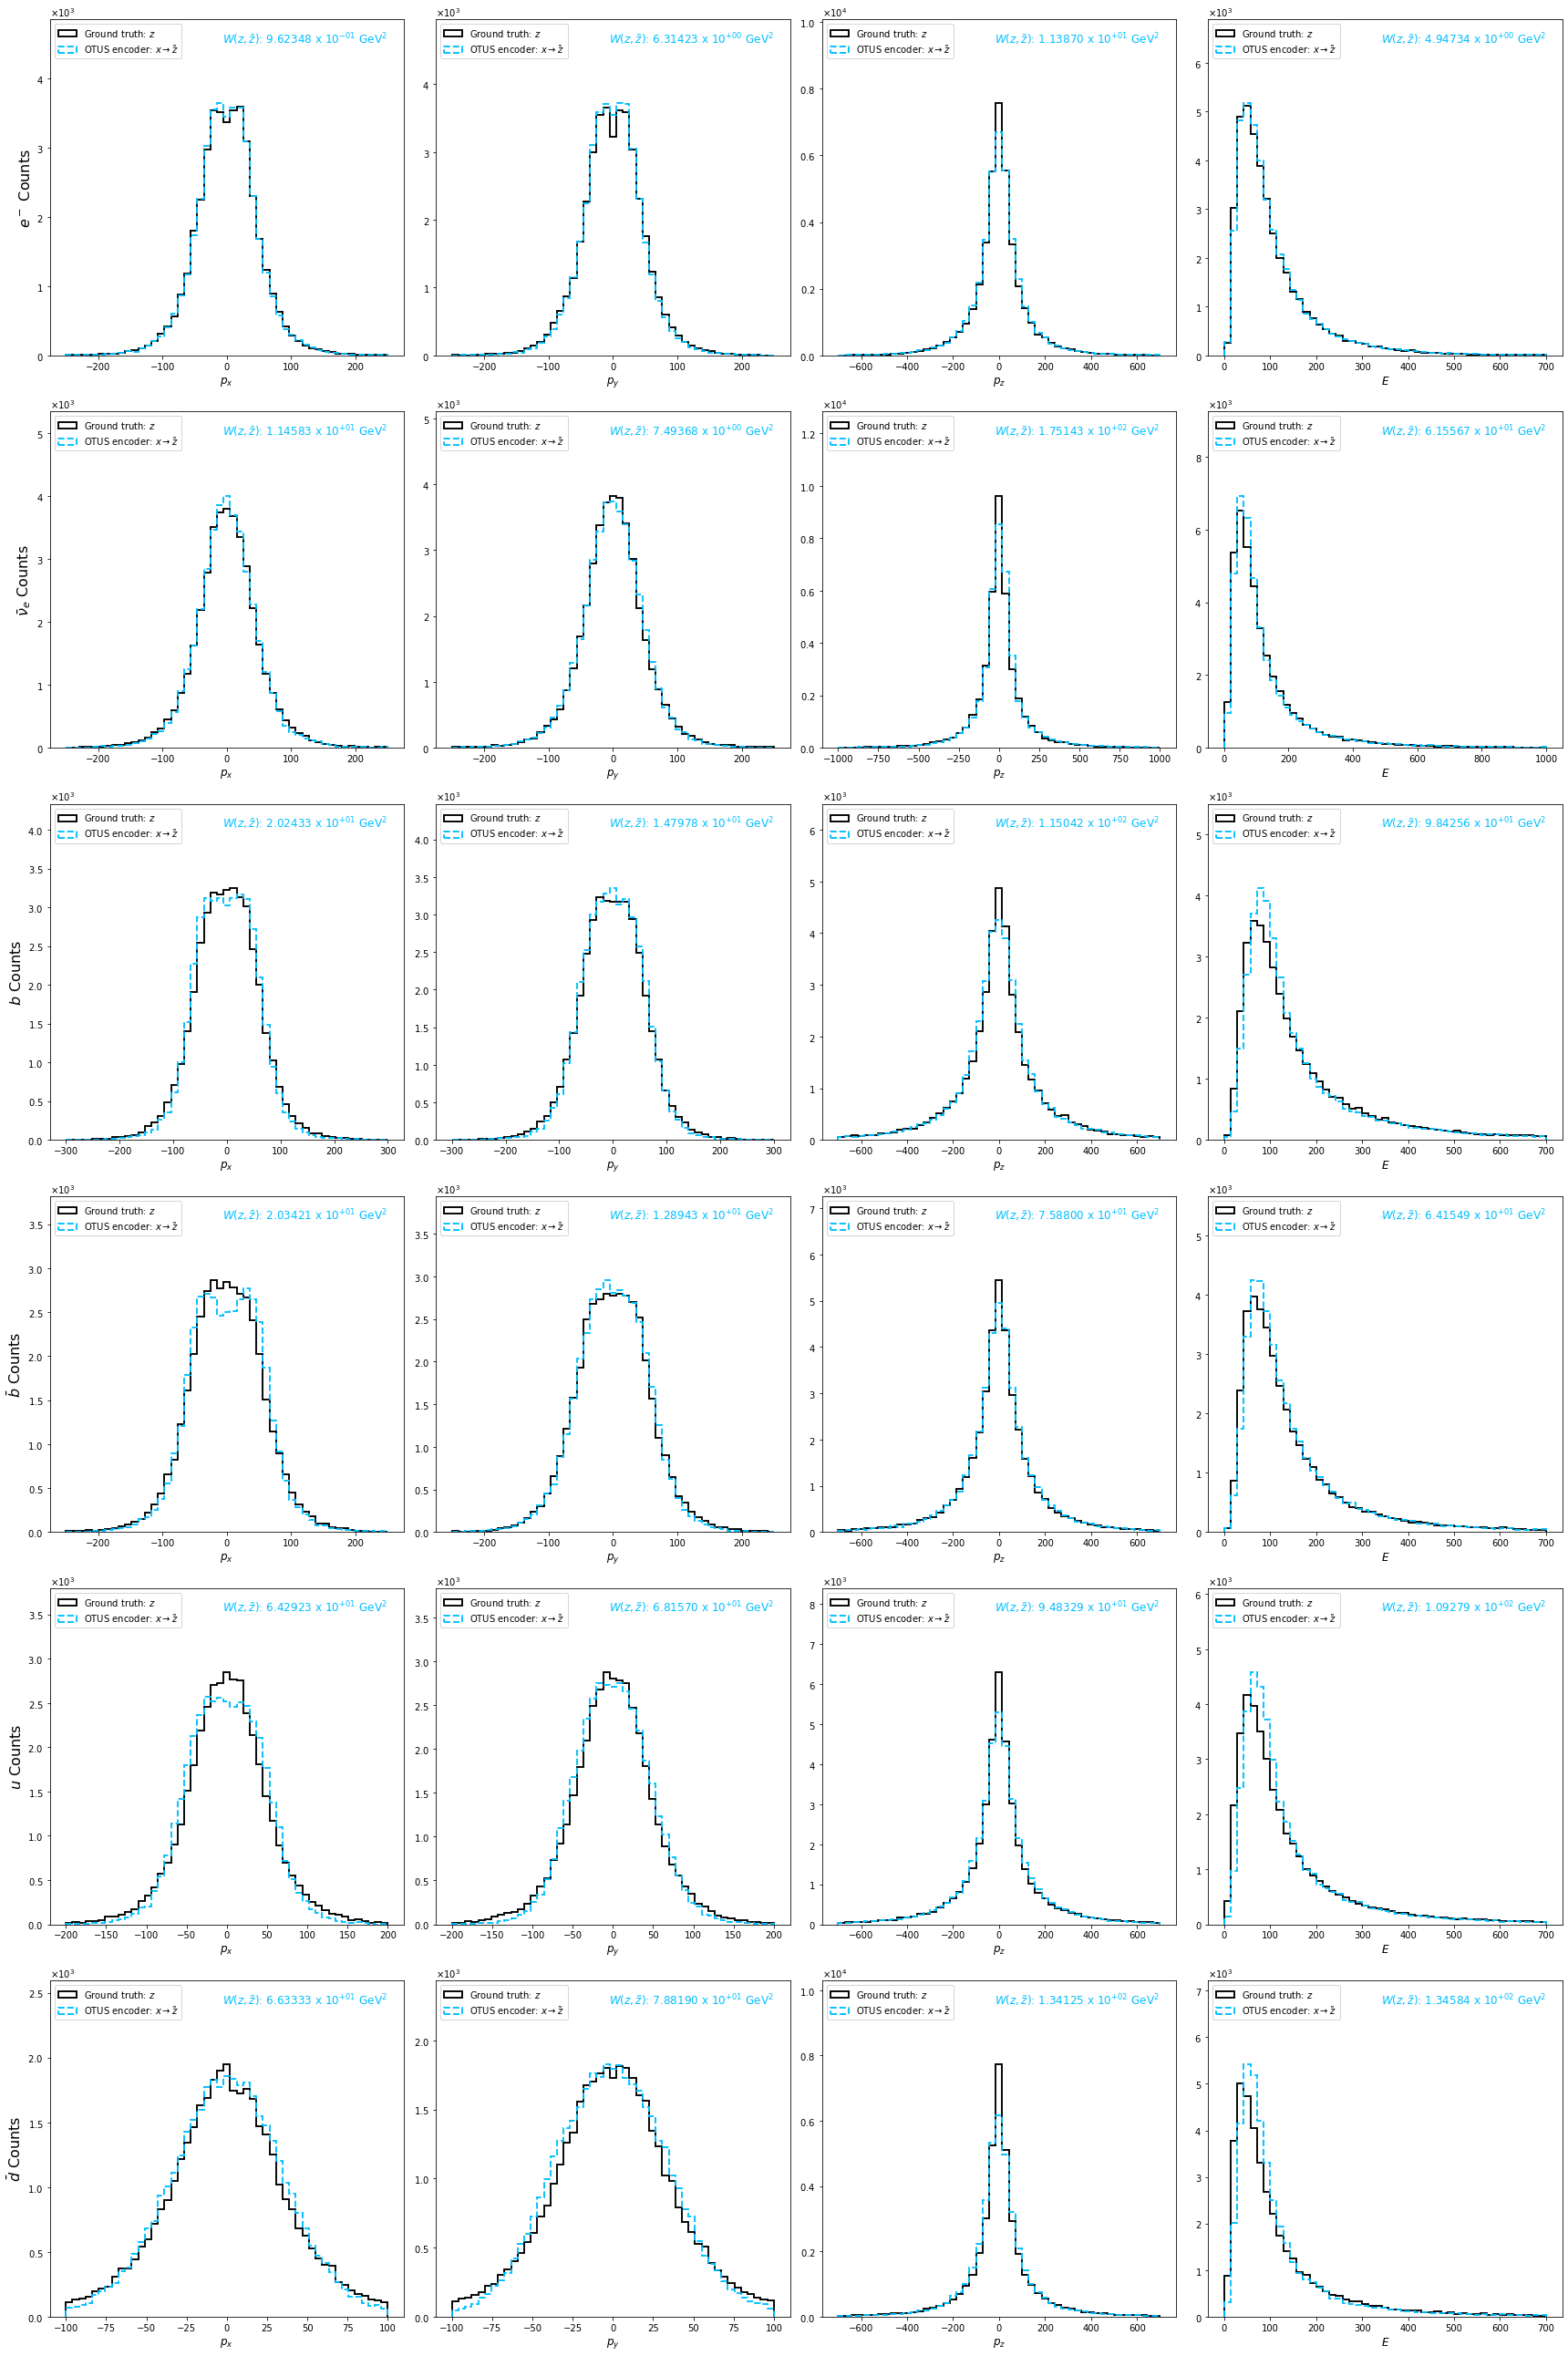

In [21]:
# Set plotting parameters
dataList = [arrs['z'], arrs['x_encoded']]
pltDim   = (6,4)
numBins  = 50
binsList = []
for i in range(pltDim[0]):
    for j in range(pltDim[1]):
        
        low  = z_display_lims[i][j][0]
        high = z_display_lims[i][j][1]
        
        binsList.append(np.linspace(low, high, numBins))

particleNameList = [r'$e^-$', r'$\bar{\nu}_e$', r'$b$', r'$\bar{b}$', r'$u$', r'$\bar{d}$']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

### x-space

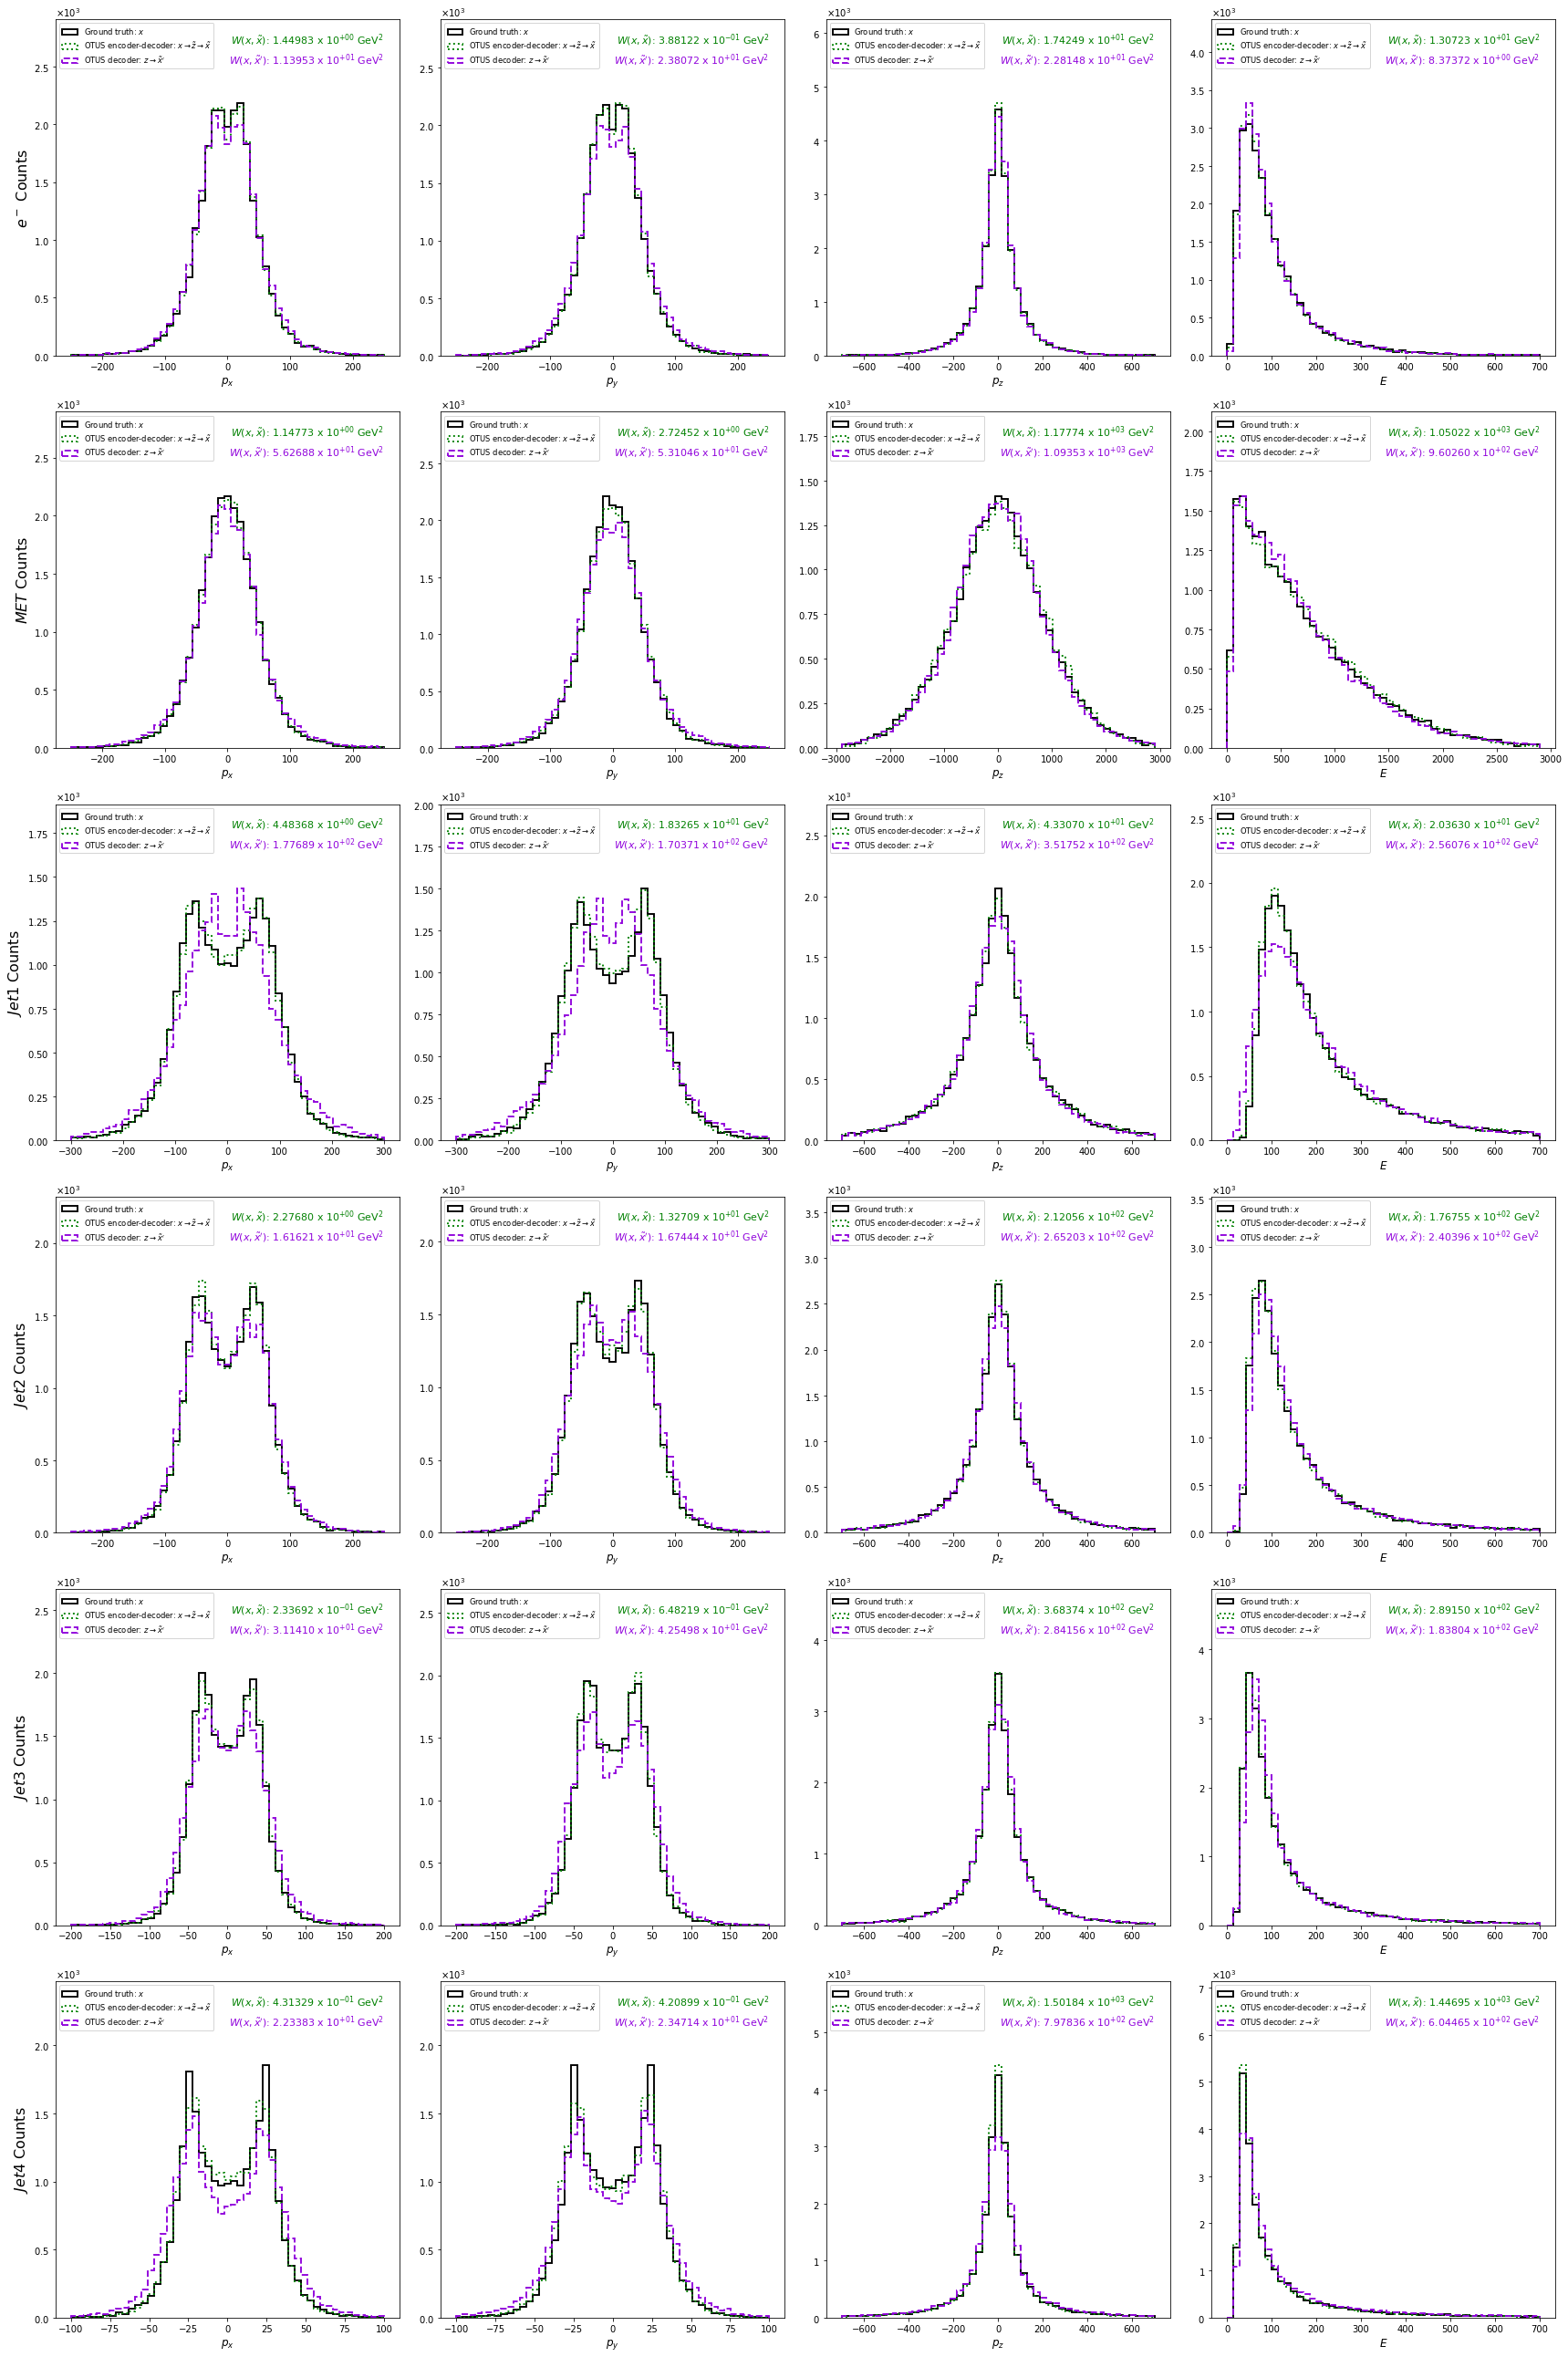

In [22]:
# Set plotting parameters
dataList = [arrs['x'], arrs['x_reconstructed_'], arrs['z_decoded_']] # Use only passing events
pltDim   = (6,4)
numBins  = 50
binsList = []
for i in range(pltDim[0]):
    for j in range(pltDim[1]):
        
        low  = x_display_lims[i][j][0]
        high = x_display_lims[i][j][1]
        
        binsList.append(np.linspace(low, high, numBins))

particleNameList = [r'$e^-$', r'$MET$', r'$Jet1$', r'$Jet2$', r'$Jet3$', r'$Jet4$']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

## Inspect Random Axes Matching on Validation Data

In [23]:
from func_utils import generateTheta

### z-space

In [24]:
# Calculate randomly projected data
true_samples = arrs['z']
num_projs = true_samples.shape[-1]

theta = generateTheta(num_projs, true_samples.shape[-1])  # np array
thetaT = theta.T
z_proj = arrs['z'] @ thetaT
x_encoded_proj = arrs['x_encoded'] @ thetaT

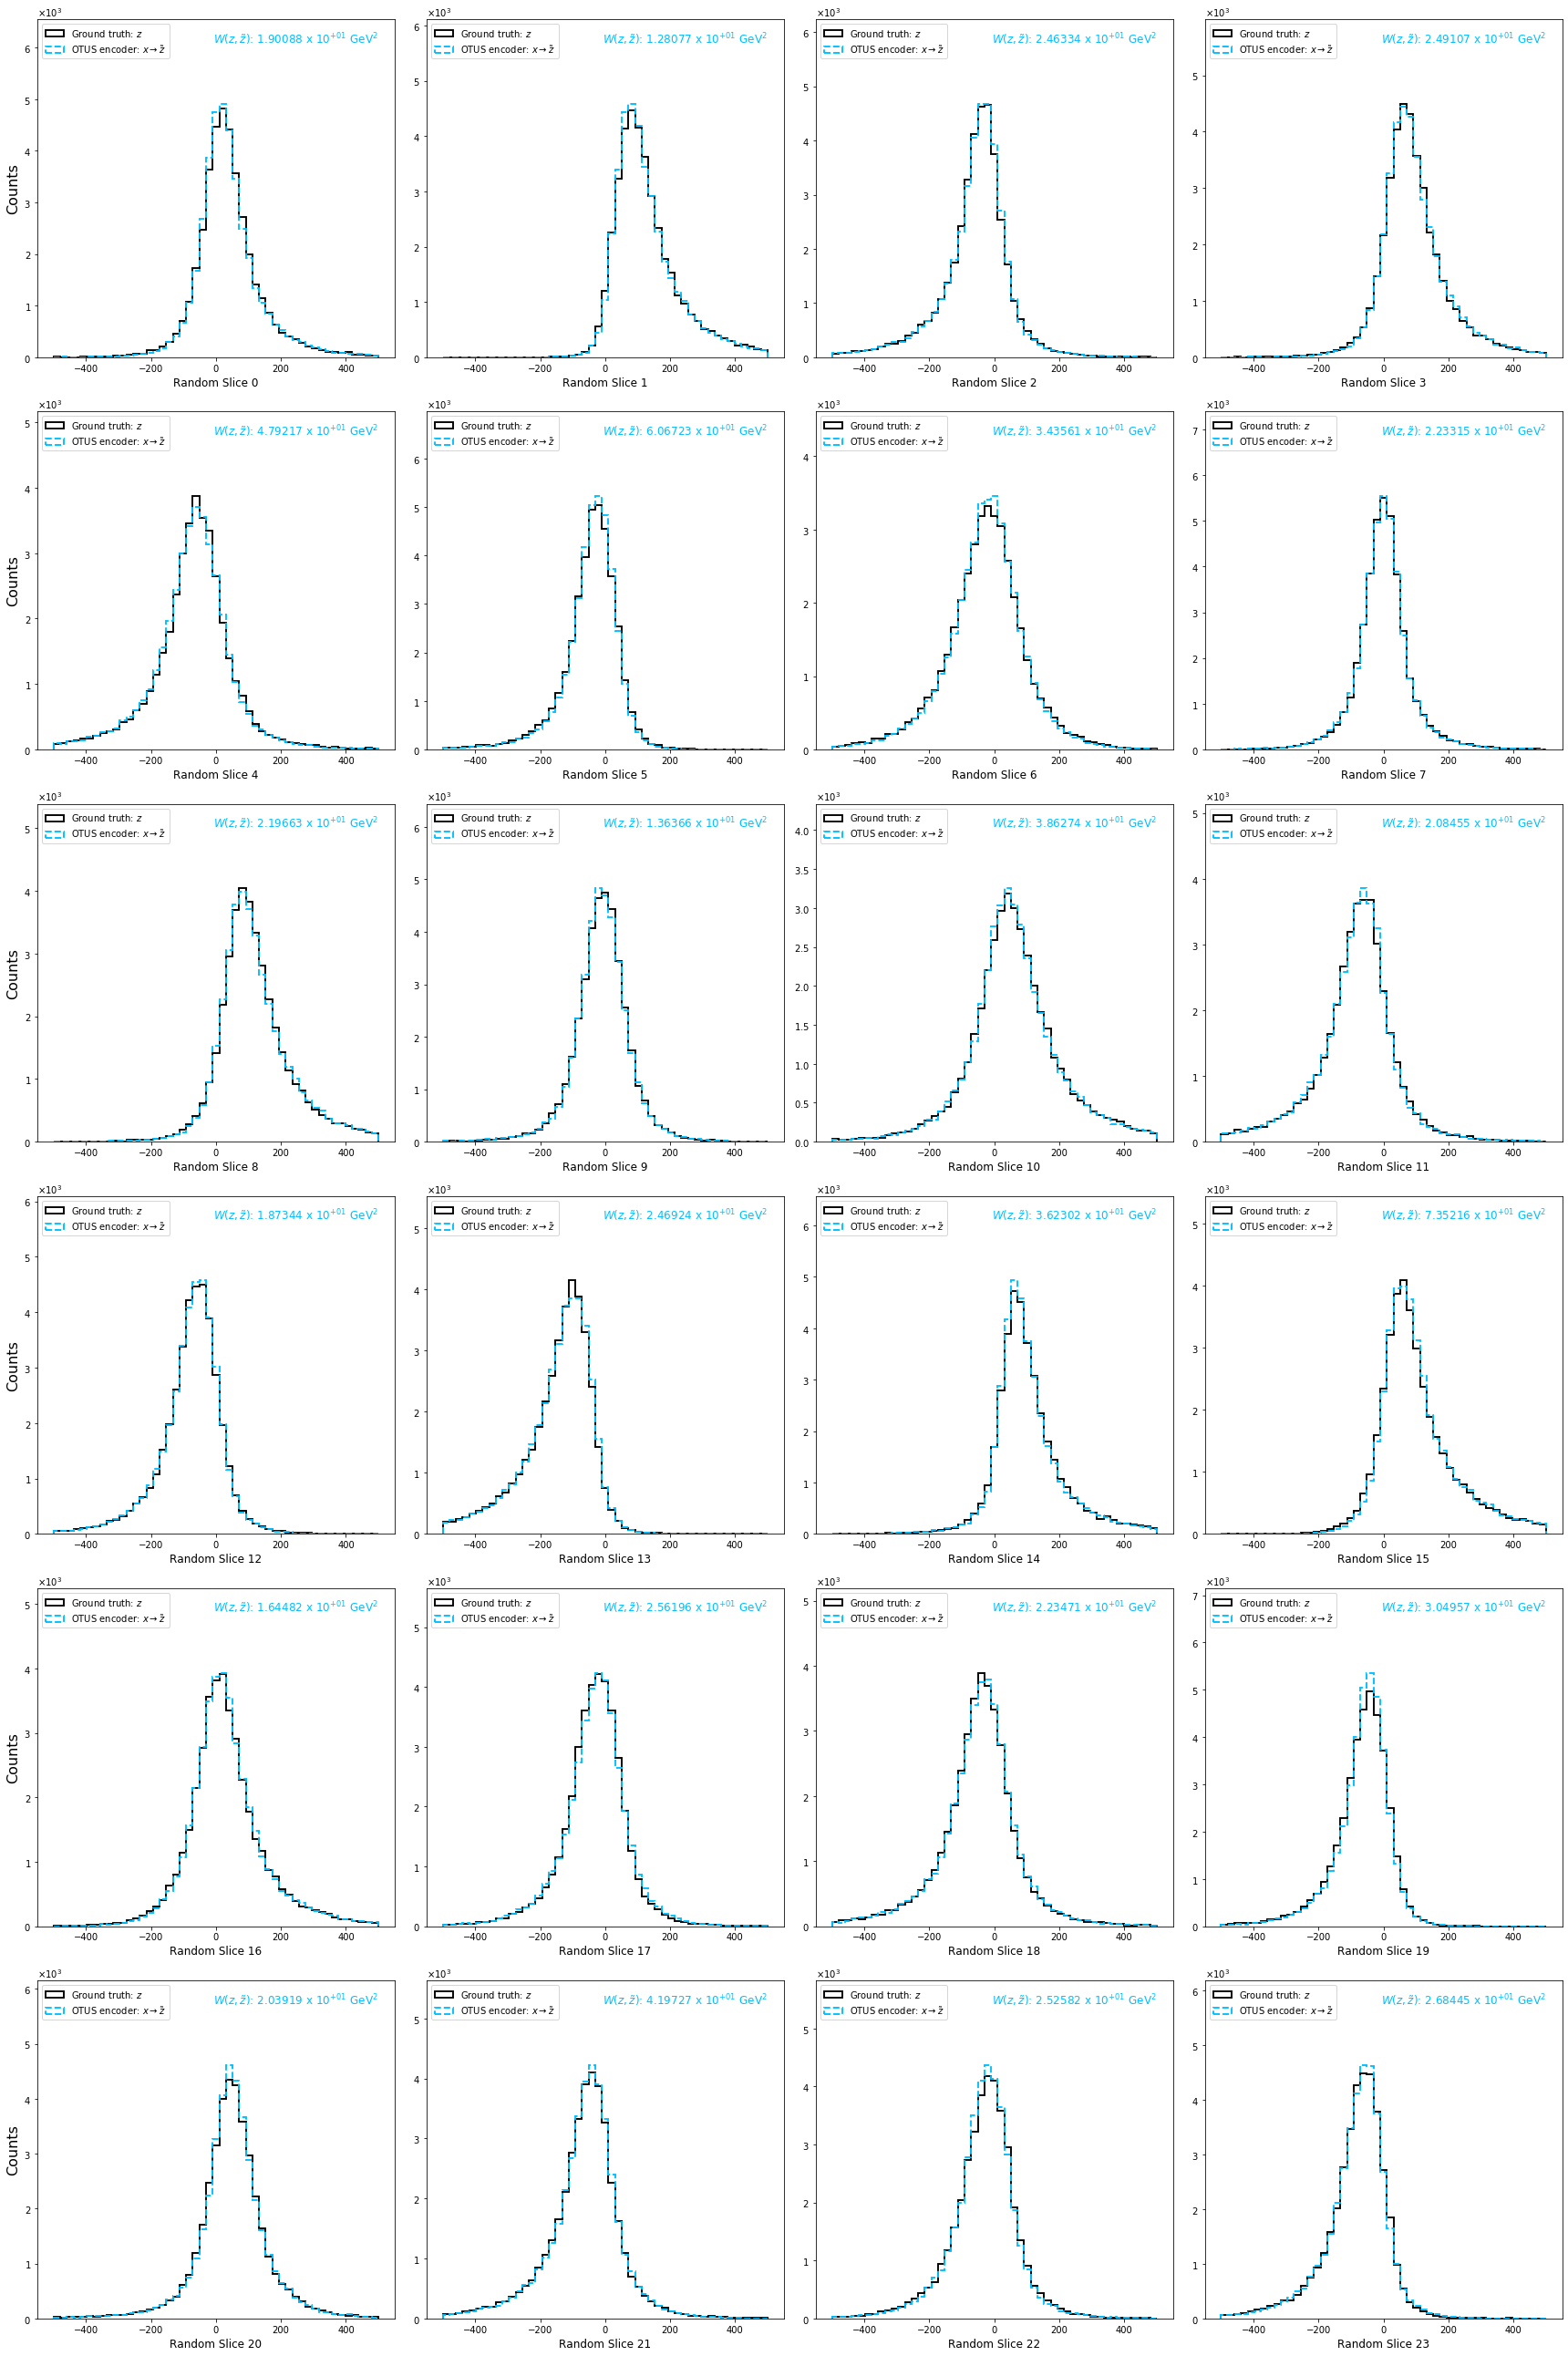

In [25]:
# Set plotting parameters
dataList = [z_proj, x_encoded_proj]

ncols = 4
assert num_projs % ncols == 0 # Make sure that numer of random projections will nicely accomodate 4 columns
nrows = num_projs // ncols
pltDim   = (nrows,ncols)

numBins  = 50
binsList = []
for i in range(num_projs):
    binsList.append(np.linspace(-500., 500., numBins)) 
particleNameList = []

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

### x-space

In [26]:
# Calculate randomly projected data
true_samples = arrs['x']
num_projs = true_samples.shape[-1]

theta = generateTheta(num_projs, true_samples.shape[-1])  # np array
thetaT = theta.T
x_proj = arrs['x'] @ thetaT
z_decoded_proj = arrs['z_decoded_'] @ thetaT
x_rec_proj = arrs['x_reconstructed_'] @ thetaT

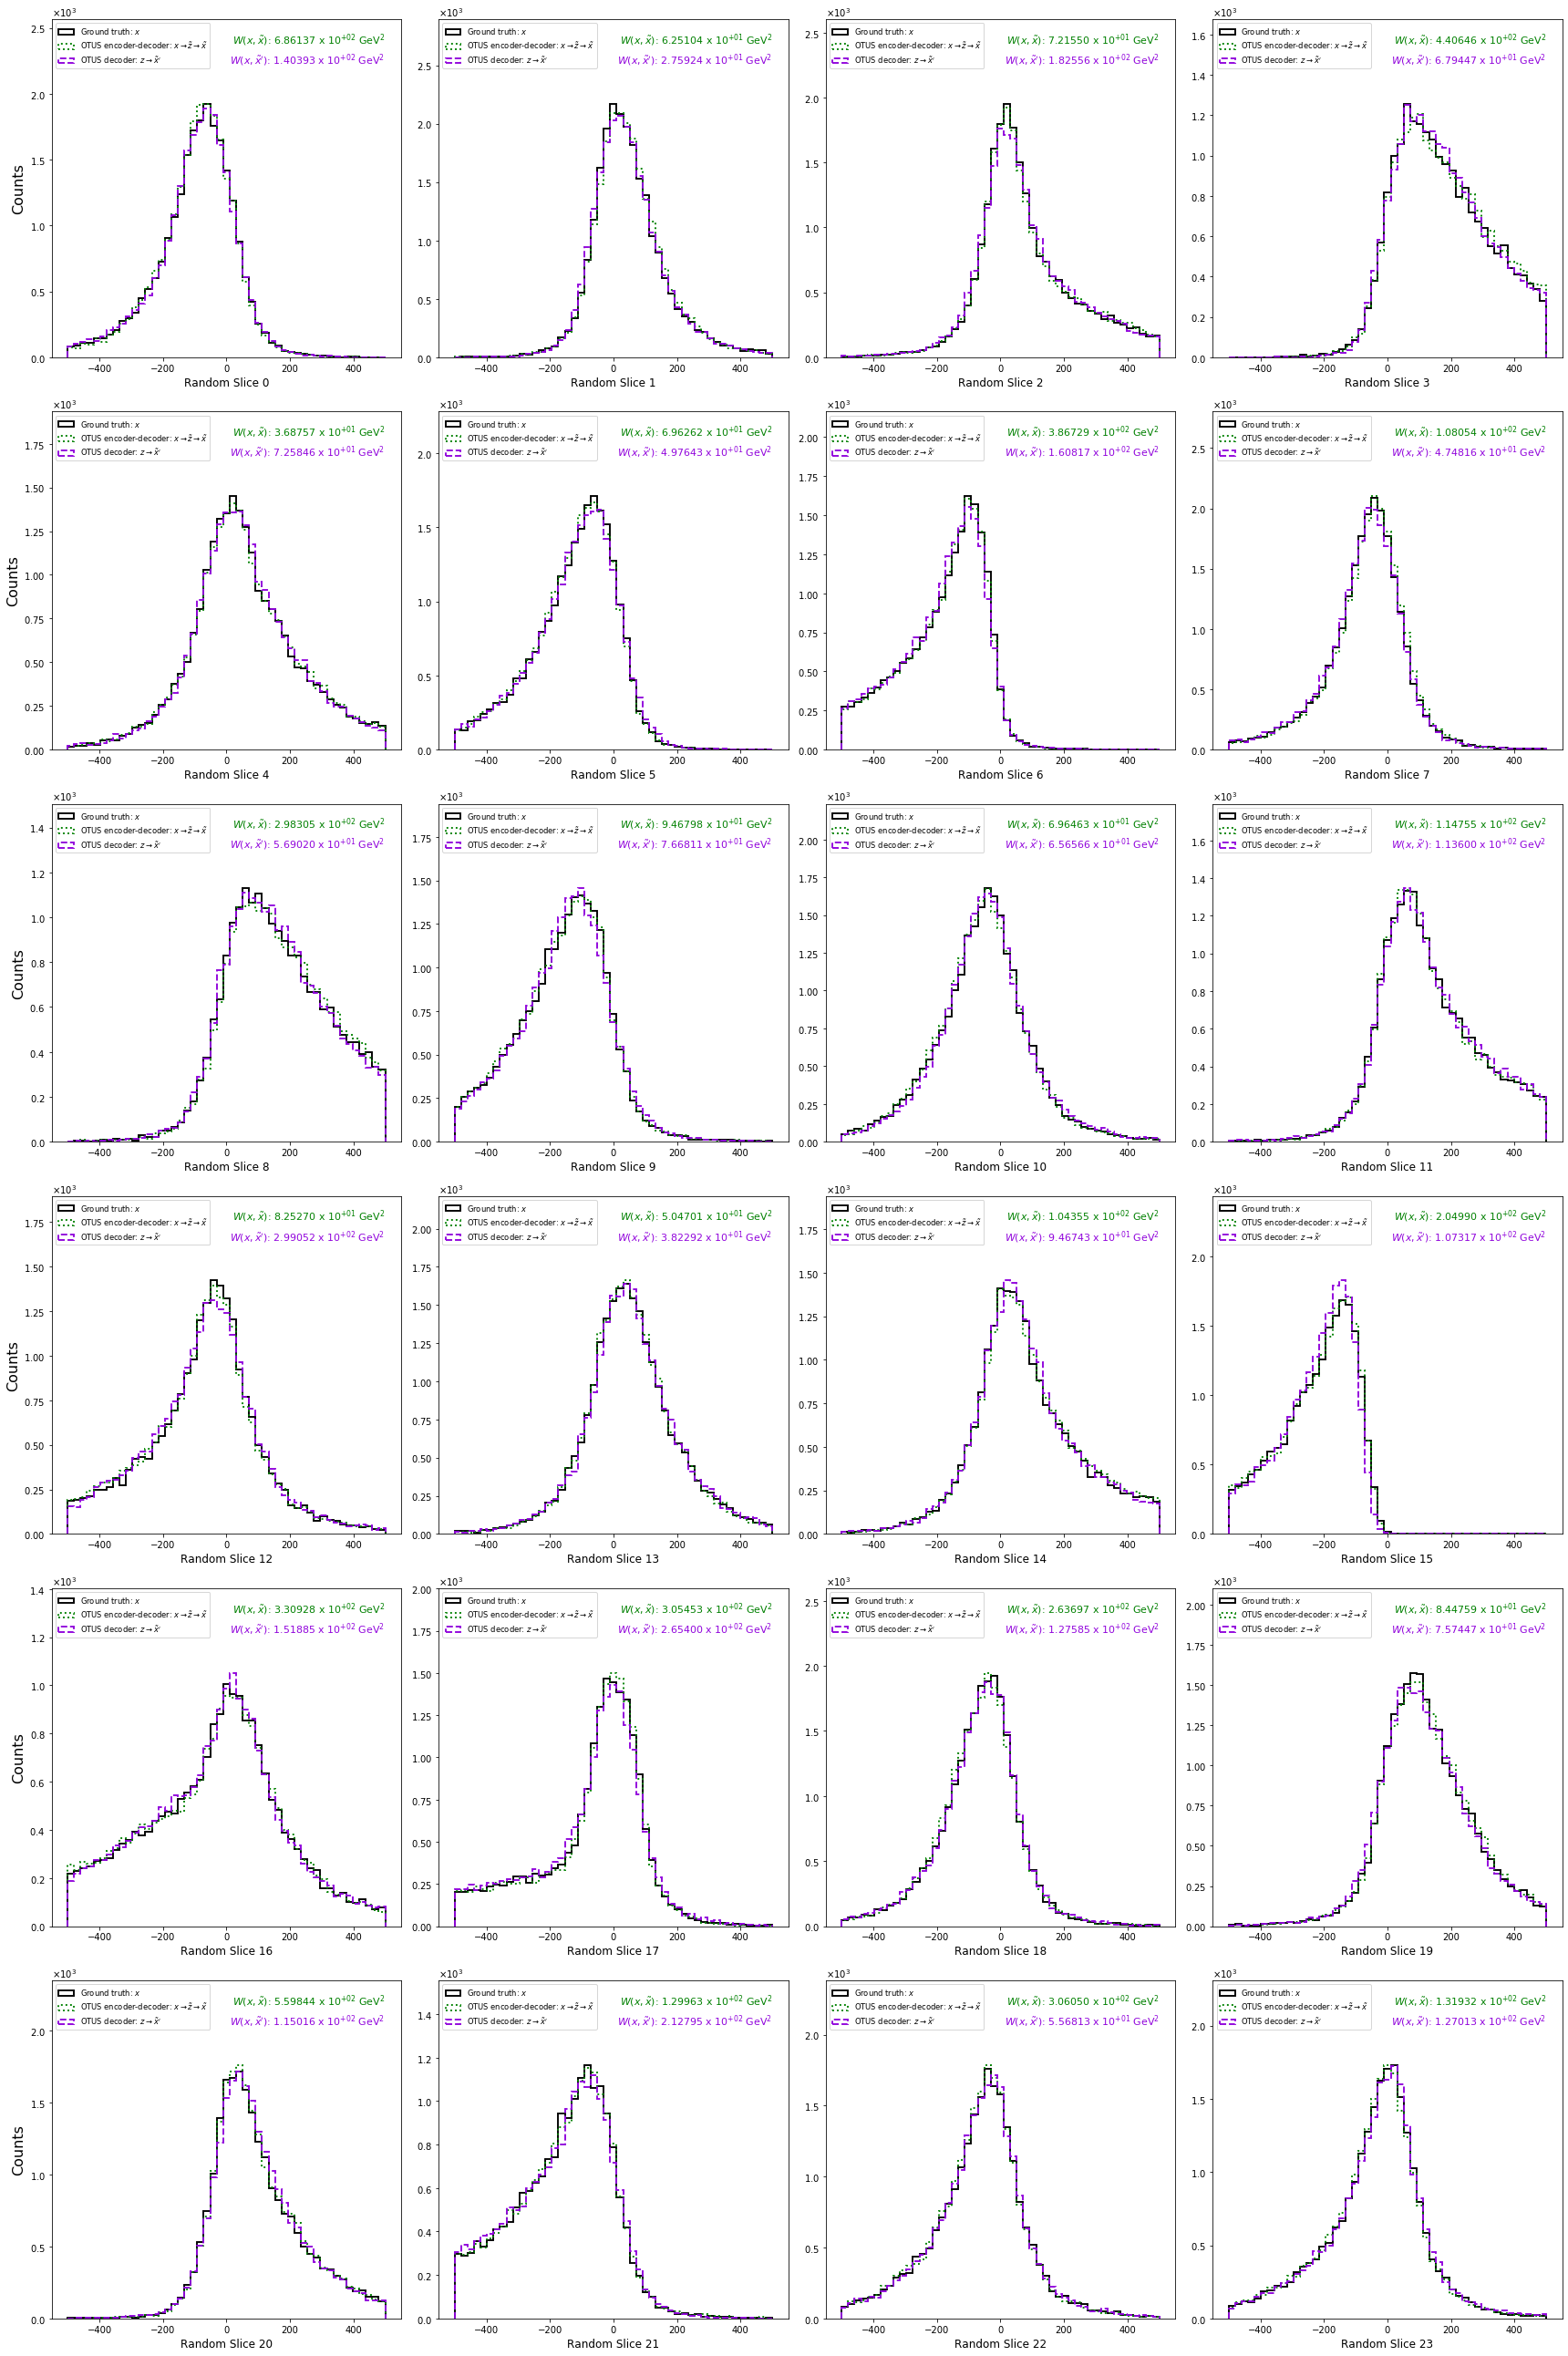

In [27]:
# Set plotting parameters
dataList = [x_proj, x_rec_proj, z_decoded_proj]

ncols = 4
assert num_projs % ncols == 0 # Make sure that numer of random projections will nicely accomodate 4 columns
nrows = num_projs // ncols
pltDim   = (nrows,ncols)

numBins  = 50
for i in range(num_projs):
    binsList.append(np.linspace(-700.,700., numBins))
particleNameList = []

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

## Inspect Derived Quantity Matching on x-space Validation Data

Here we test the distribution matching on a variety of derived quantities (5 in total). 
- $M_{t \bar{t}}$
- $M_{W, leptonic}$
- $M_{W, hadronic}$
- $M_{t, leptonic}$
- $M_{t, hadronic}$

In [28]:
from top_masses import ttbar_masses

In [29]:
data_key = 'val'
arrs = all_arrs[data_key]

### Calculate derived quantities

In [30]:
# Create new arrays from model output that passes cuts

for data_key in 'train', 'val':
    arrs = all_arrs[data_key]
    for field in ('z_decoded', 'x_reconstructed'):
        arr = arrs[field]
        
        if raw_io:
            arr_raw = arr
        else:
            arr_raw = (arr * x_train_std) + x_train_mean
        
        # Keep only events that pass threshold constraint
        good_mask = threshold_check(arr_raw)
        print('Passing rate of', field, good_mask.mean())
        arr_raw = arr_raw[good_mask] 
        
        if raw_io:
            arr = arr_raw
        else:
            arr = (arr_raw - x_train_mean) / x_train_std
        
        arrs[field+'_'] = arr
        
        if field == 'z_decoded':
            arrs['z_decoded_good_mask'] = good_mask
            arrs['z_'] = arrs['z'][good_mask]
        else:
            arrs['x_encoded_'] = arrs['x_encoded'][good_mask]

Passing rate of z_decoded 0.594722595068257
Passing rate of x_reconstructed 0.8953811484056904
Passing rate of z_decoded 0.599225
Passing rate of x_reconstructed 0.895275


In [31]:
for field in 'x', 'z_decoded', 'x_reconstructed':
    
    # Check if this has been calculated for x already 
    if field == 'x' and isinstance(arrs.get(field+'_masses'), np.ndarray): 
        continue
    
    arr = arrs[field]
    
    if raw_io:
        arr_raw = arr
    else:
        arr_raw = (arr * x_train_std) + x_train_mean
    
    # Keep only events that pass threshold constraint
    good_mask = threshold_check(arr_raw)
    print('Passing rate of', field, good_mask.mean())
    arr_raw = arr_raw[good_mask]
    
    # Calculate invariant mass derived quantities
    masses = []
    mass_keys = 'mttbar', 'mwlep', 'mwhad', 'mtoplep', 'mtophad'
    for x in arr_raw:
        mttbar, mwlep, mwhad, mtoplep, mtophad = ttbar_masses(list(x))
        masses.append(np.array([mttbar, mwlep, mwhad, mtoplep, mtophad]))
    masses = np.asarray(masses)
    arrs[field+'_masses'] = masses

Passing rate of x 0.99145
Passing rate of z_decoded 0.599225
Passing rate of x_reconstructed 0.895275


### Plot derived quantities

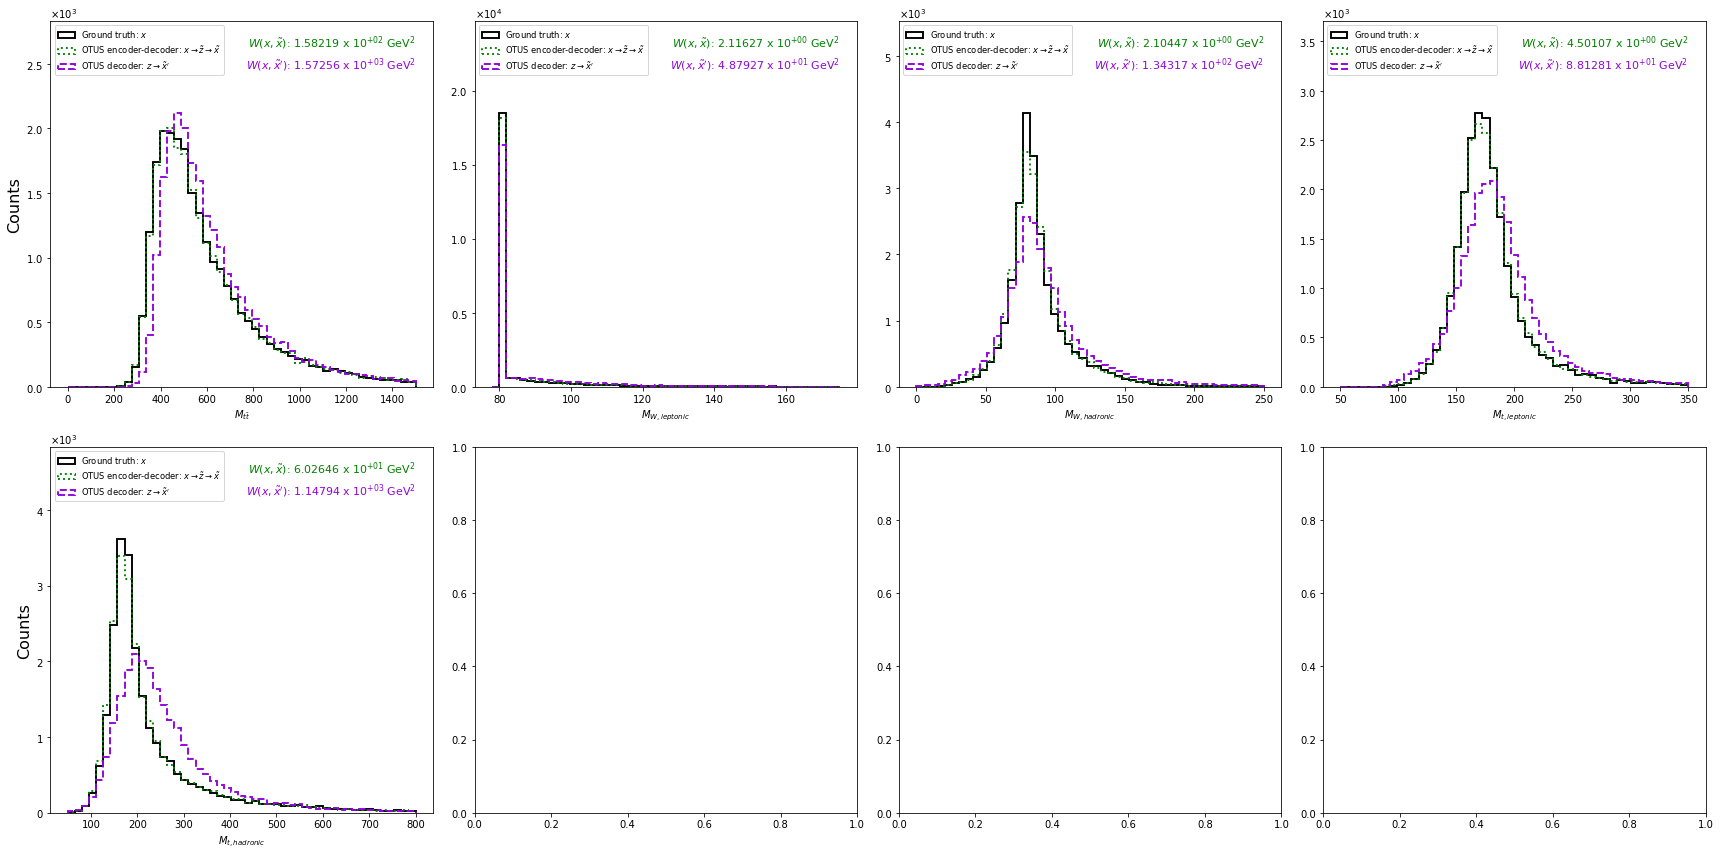

In [32]:
# Set plotting parameters
dataList = [arrs['x_masses'], arrs['x_reconstructed_masses'],arrs['z_decoded_masses']] 
pltDim   = (2,4)
numBins  = 50
mass_lims = [(0,1500), (78, 175), (0,250), (50,350), (50,800)]
binsList = []
for i in range(len(mass_lims)):
    low  = mass_lims[i][0]
    high = mass_lims[i][1]
        
    binsList.append(np.linspace(low, high, numBins))
particleNameList = []
nameList = [r'$M_{t \bar{t}}$', r'$M_{W, leptonic}$', r'$M_{W, hadronic}$', r'$M_{t, leptonic}$', r'$M_{t, hadronic}$']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList=binsList, particleNameList=particleNameList, nameList=nameList)

## Inspect 2D Qualities of the Results on Validation Data

In [33]:
from plot_utils import compare_hist2d

In [34]:
data_key = 'val'
arrs = all_arrs[data_key]

### z-data

#### Compare $b$ quark's $p_x$ vs $p_y$ in 2D plot

x range: -607.6515 524.949
y range: -571.8274 576.1572
x range: -466.6315 551.1687
y range: -569.217 514.4372


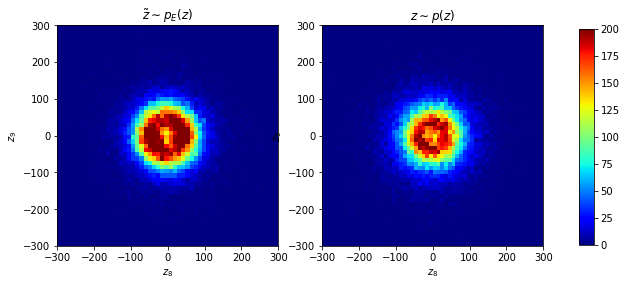

In [35]:
# Set plotting parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([8, 9]) # 8 for px, 9 for py of the b quark
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 200 # cmap range
cmap       = 'jet'
xlim       = [-300, 300]
ylim       = [-300, 300]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare $b$ quark's $p_y$ vs $p_z$ in 2D plot

x range: -571.8274 576.1572
y range: -2399.192 3247.9673
x range: -569.217 514.4372
y range: -2660.4194 3041.1423


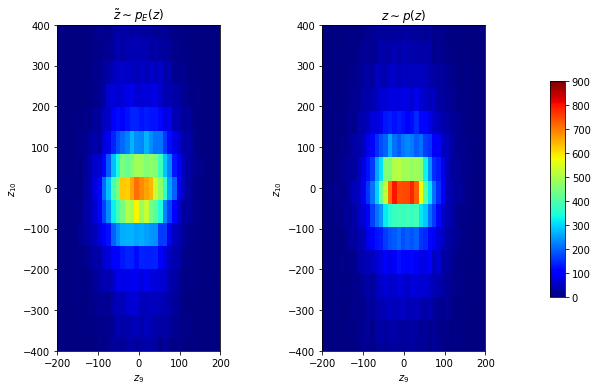

In [36]:
# Set plotting parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([9, 10]) # 9 for py, 10 for pz of the b quark
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 900 # cmap range
cmap       = 'jet'
xlim       = [-200, 200]
ylim       = [-400, 400]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare $b$ quark's $p_z$ vs $E$ in 2D plot

x range: -2399.192 3247.9673
y range: 6.5278587 3249.93
x range: -2660.4194 3041.1423
y range: 6.4899707 3044.6074


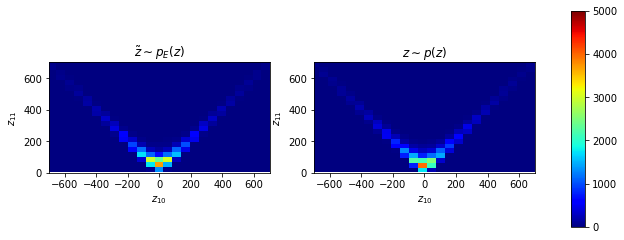

In [37]:
# Set plotting parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([10, 11]) # 10 for pz, 11 for E of the b quark
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 5000 # cmap range
cmap       = 'jet'
xlim       = [-700, 700]
ylim       = [0, 700]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

### x-data

#### Compare leading jet's $p_x$ vs $p_y$ in 2D plot

x range: -910.99664 883.0934
y range: -1103.9946 694.7269
x range: -853.51117 576.70074
y range: -880.91736 731.83167


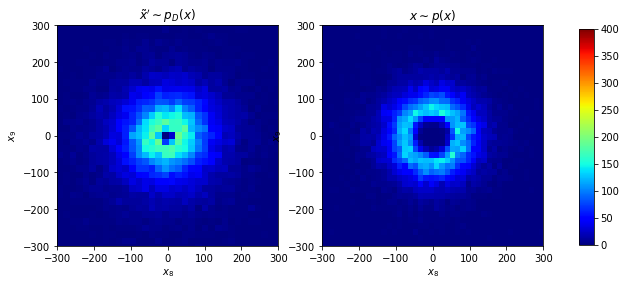

In [38]:
# Set plotting parameters
dataList   = [arrs['z_decoded_'], arrs['x']]
coords     = np.array([8, 9]) # 8 for px, 9 for py of the leading jet
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 400 # cmap range
cmap       = 'jet'
xlim       = [-300, 300]
ylim       = [-300, 300]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare leading jet's $p_y$ vs $p_z$ in 2D plot

x range: -1103.9946 694.7269
y range: -3766.8896 3448.8032
x range: -880.91736 731.83167
y range: -3947.667 4672.745


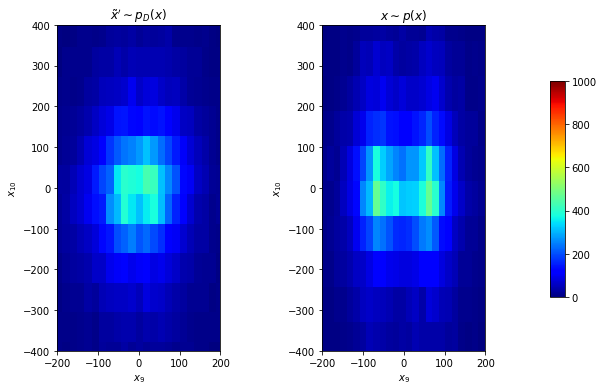

In [39]:
# Set plotting parameters
dataList   = [arrs['z_decoded_'], arrs['x']]
coords     = np.array([9, 10]) # 9 for py, 10 for pz of the leading jet
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 1000 # cmap range
cmap       = 'jet'
xlim       = [-200, 200]
ylim       = [-400, 400]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare leading jet's $p_z$ vs $E$ in 2D plot

x range: -3766.8896 4022.7239
y range: 3.5902731 4027.2732
x range: -3947.667 4672.745
y range: 31.404186 4676.3794


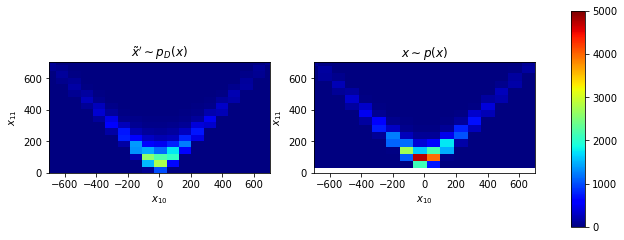

In [40]:
# Set plotting parameters
dataList   = [arrs['z_decoded'], arrs['x']]
coords     = np.array([10, 11]) # 10 for pz, 11 for E of the leading jet
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 5000 # cmap range
cmap       = 'jet'
xlim       = [-700, 700]
ylim       = [0, 700]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

## Inspect Mappings with Transport Plots on Validation Data

Note that transport plots take a while to render.

In [41]:
from plot_utils import fullTransportPlot

In [42]:
data_key = 'val'
arrs = all_arrs[data_key]

### Decoder mappings

In [43]:
nzList    = np.repeat(20,24).tolist()
nxList    = nzList
# z_display_lims and x_display_lims defined above
limzList = sum(z_display_lims, [])
limxList  = sum(x_display_lims, [])
pltDim    = (6,4)
titleList = [r'$p_x$',r'$p_y$',r'$p_z$',r'$E$','','','','','','','','','','','','','','','','','','','','']

#### Transport plans for $z$ -> $\tilde{x}^\prime$

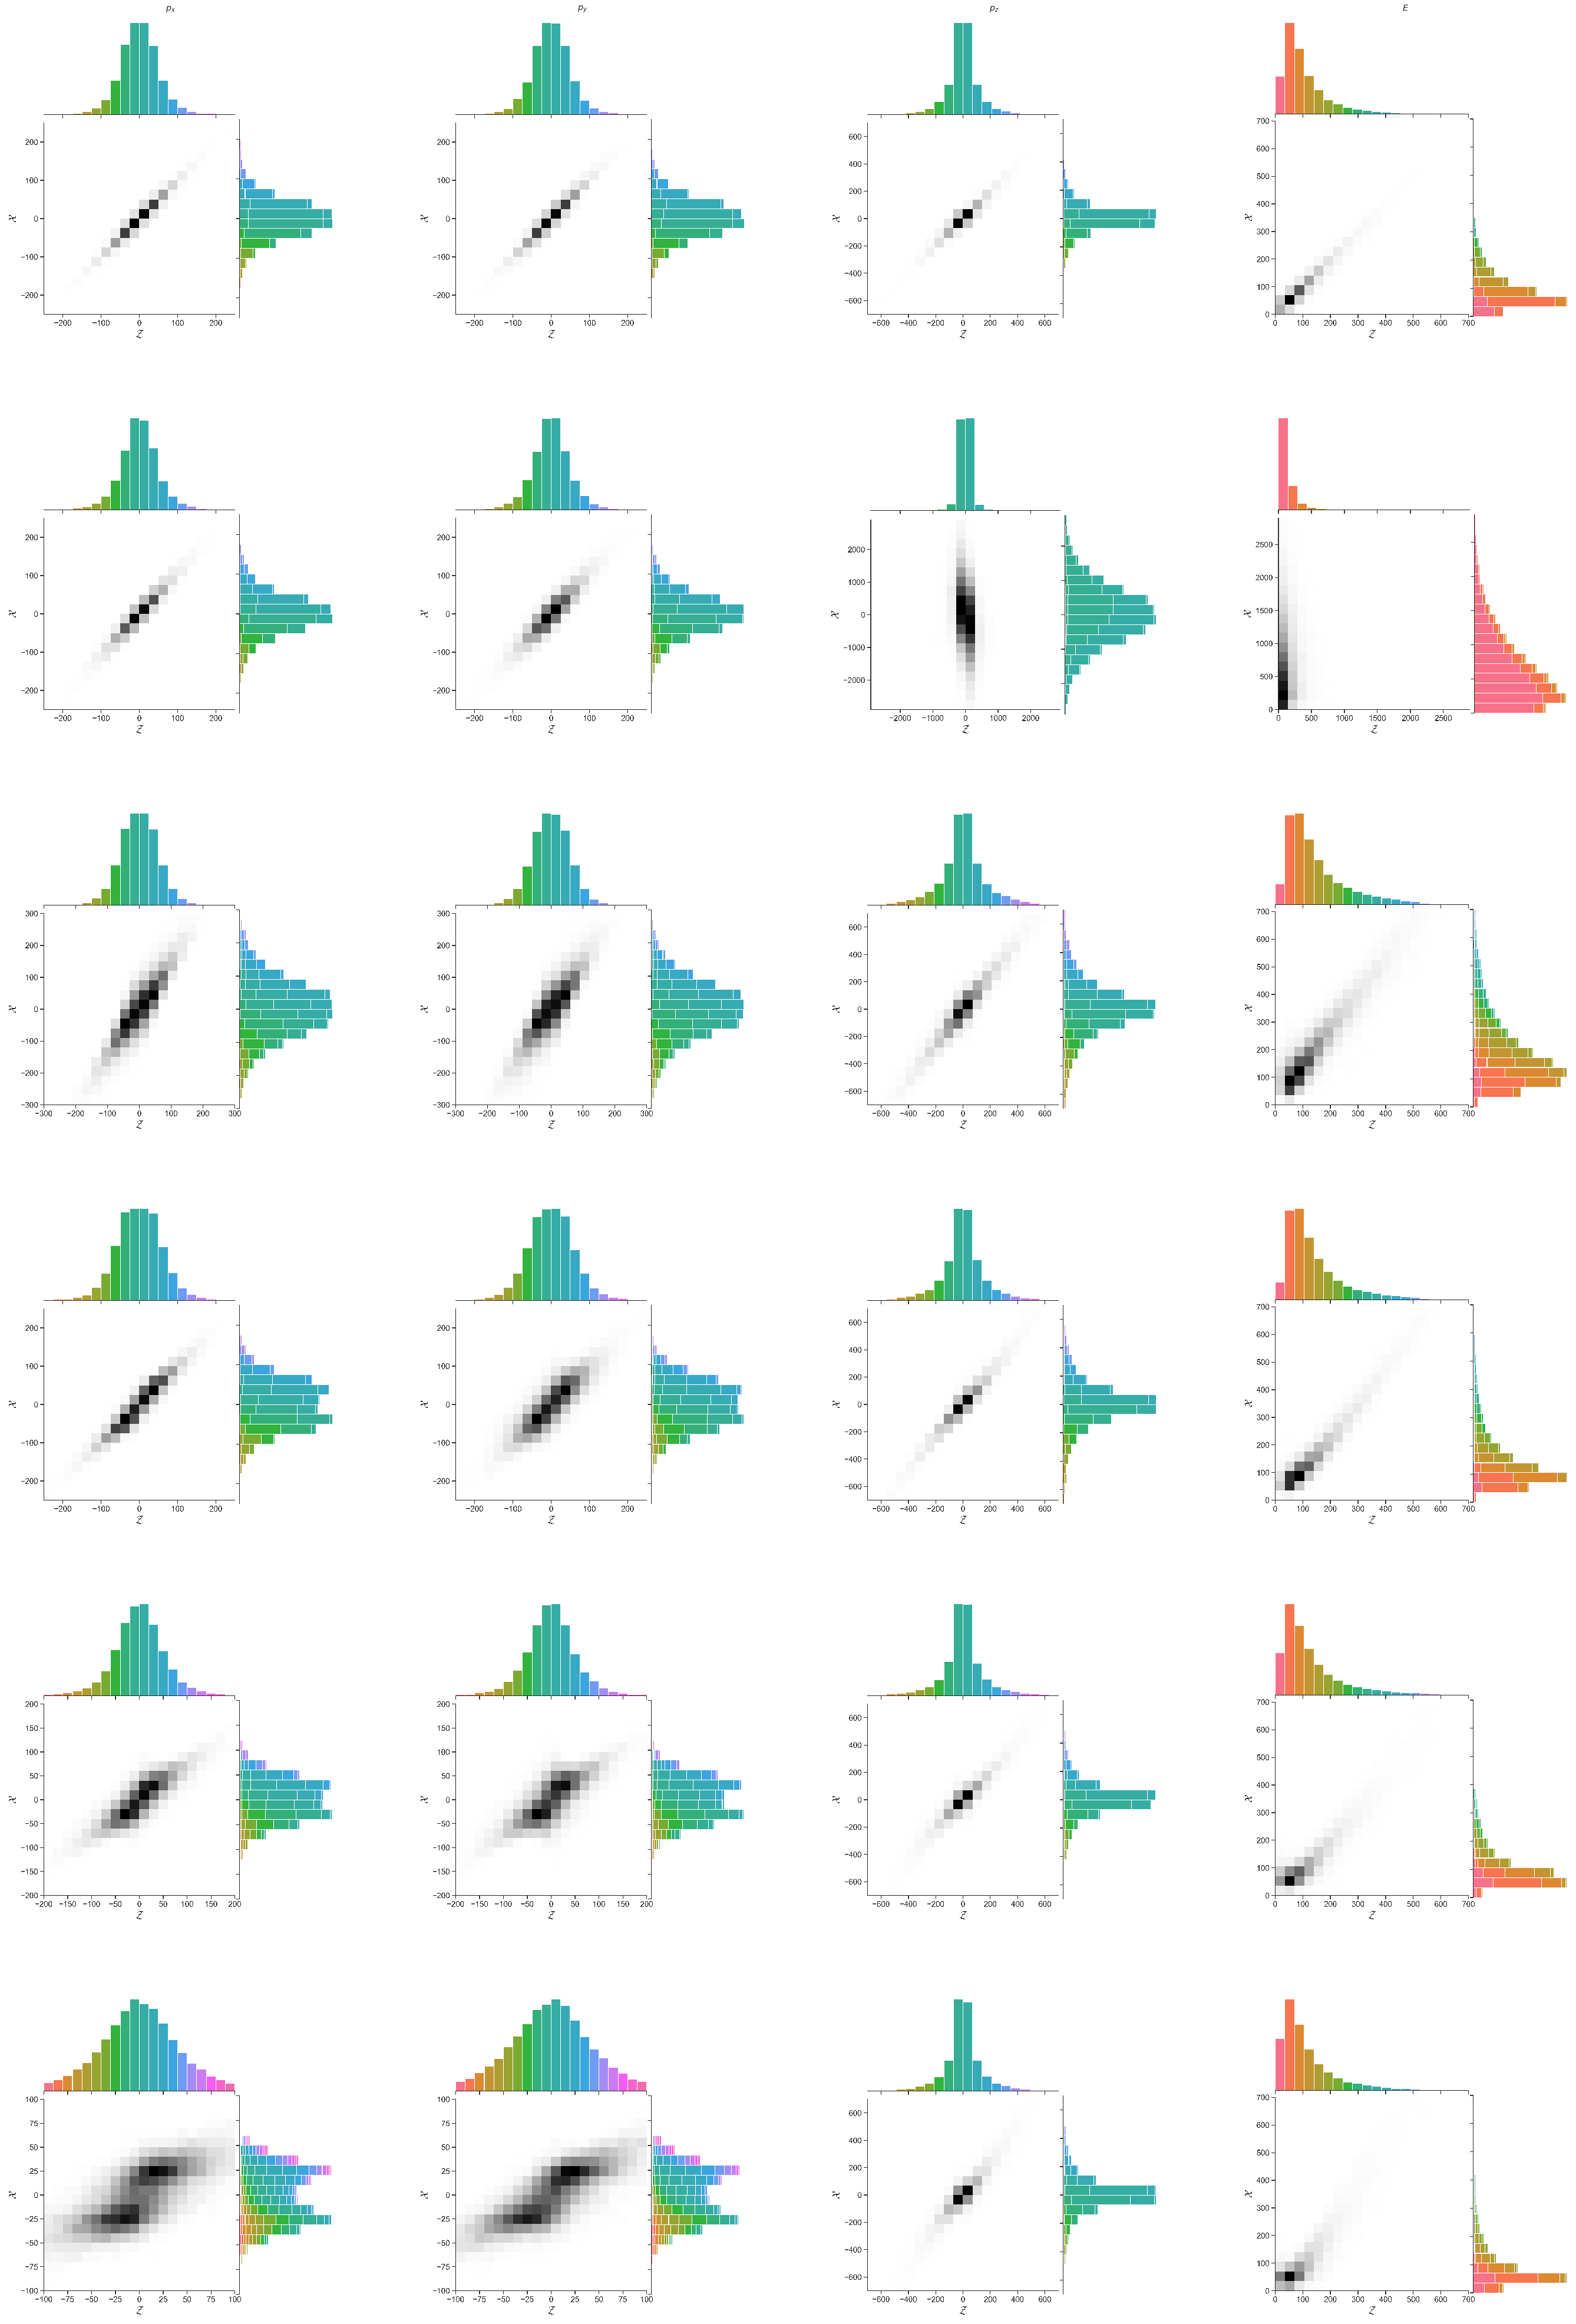

In [44]:
fullTransportPlot(arrs['z_'], arrs['z_decoded_'], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

#### Transport plans for $\tilde{z}$ -> $\tilde{x}$

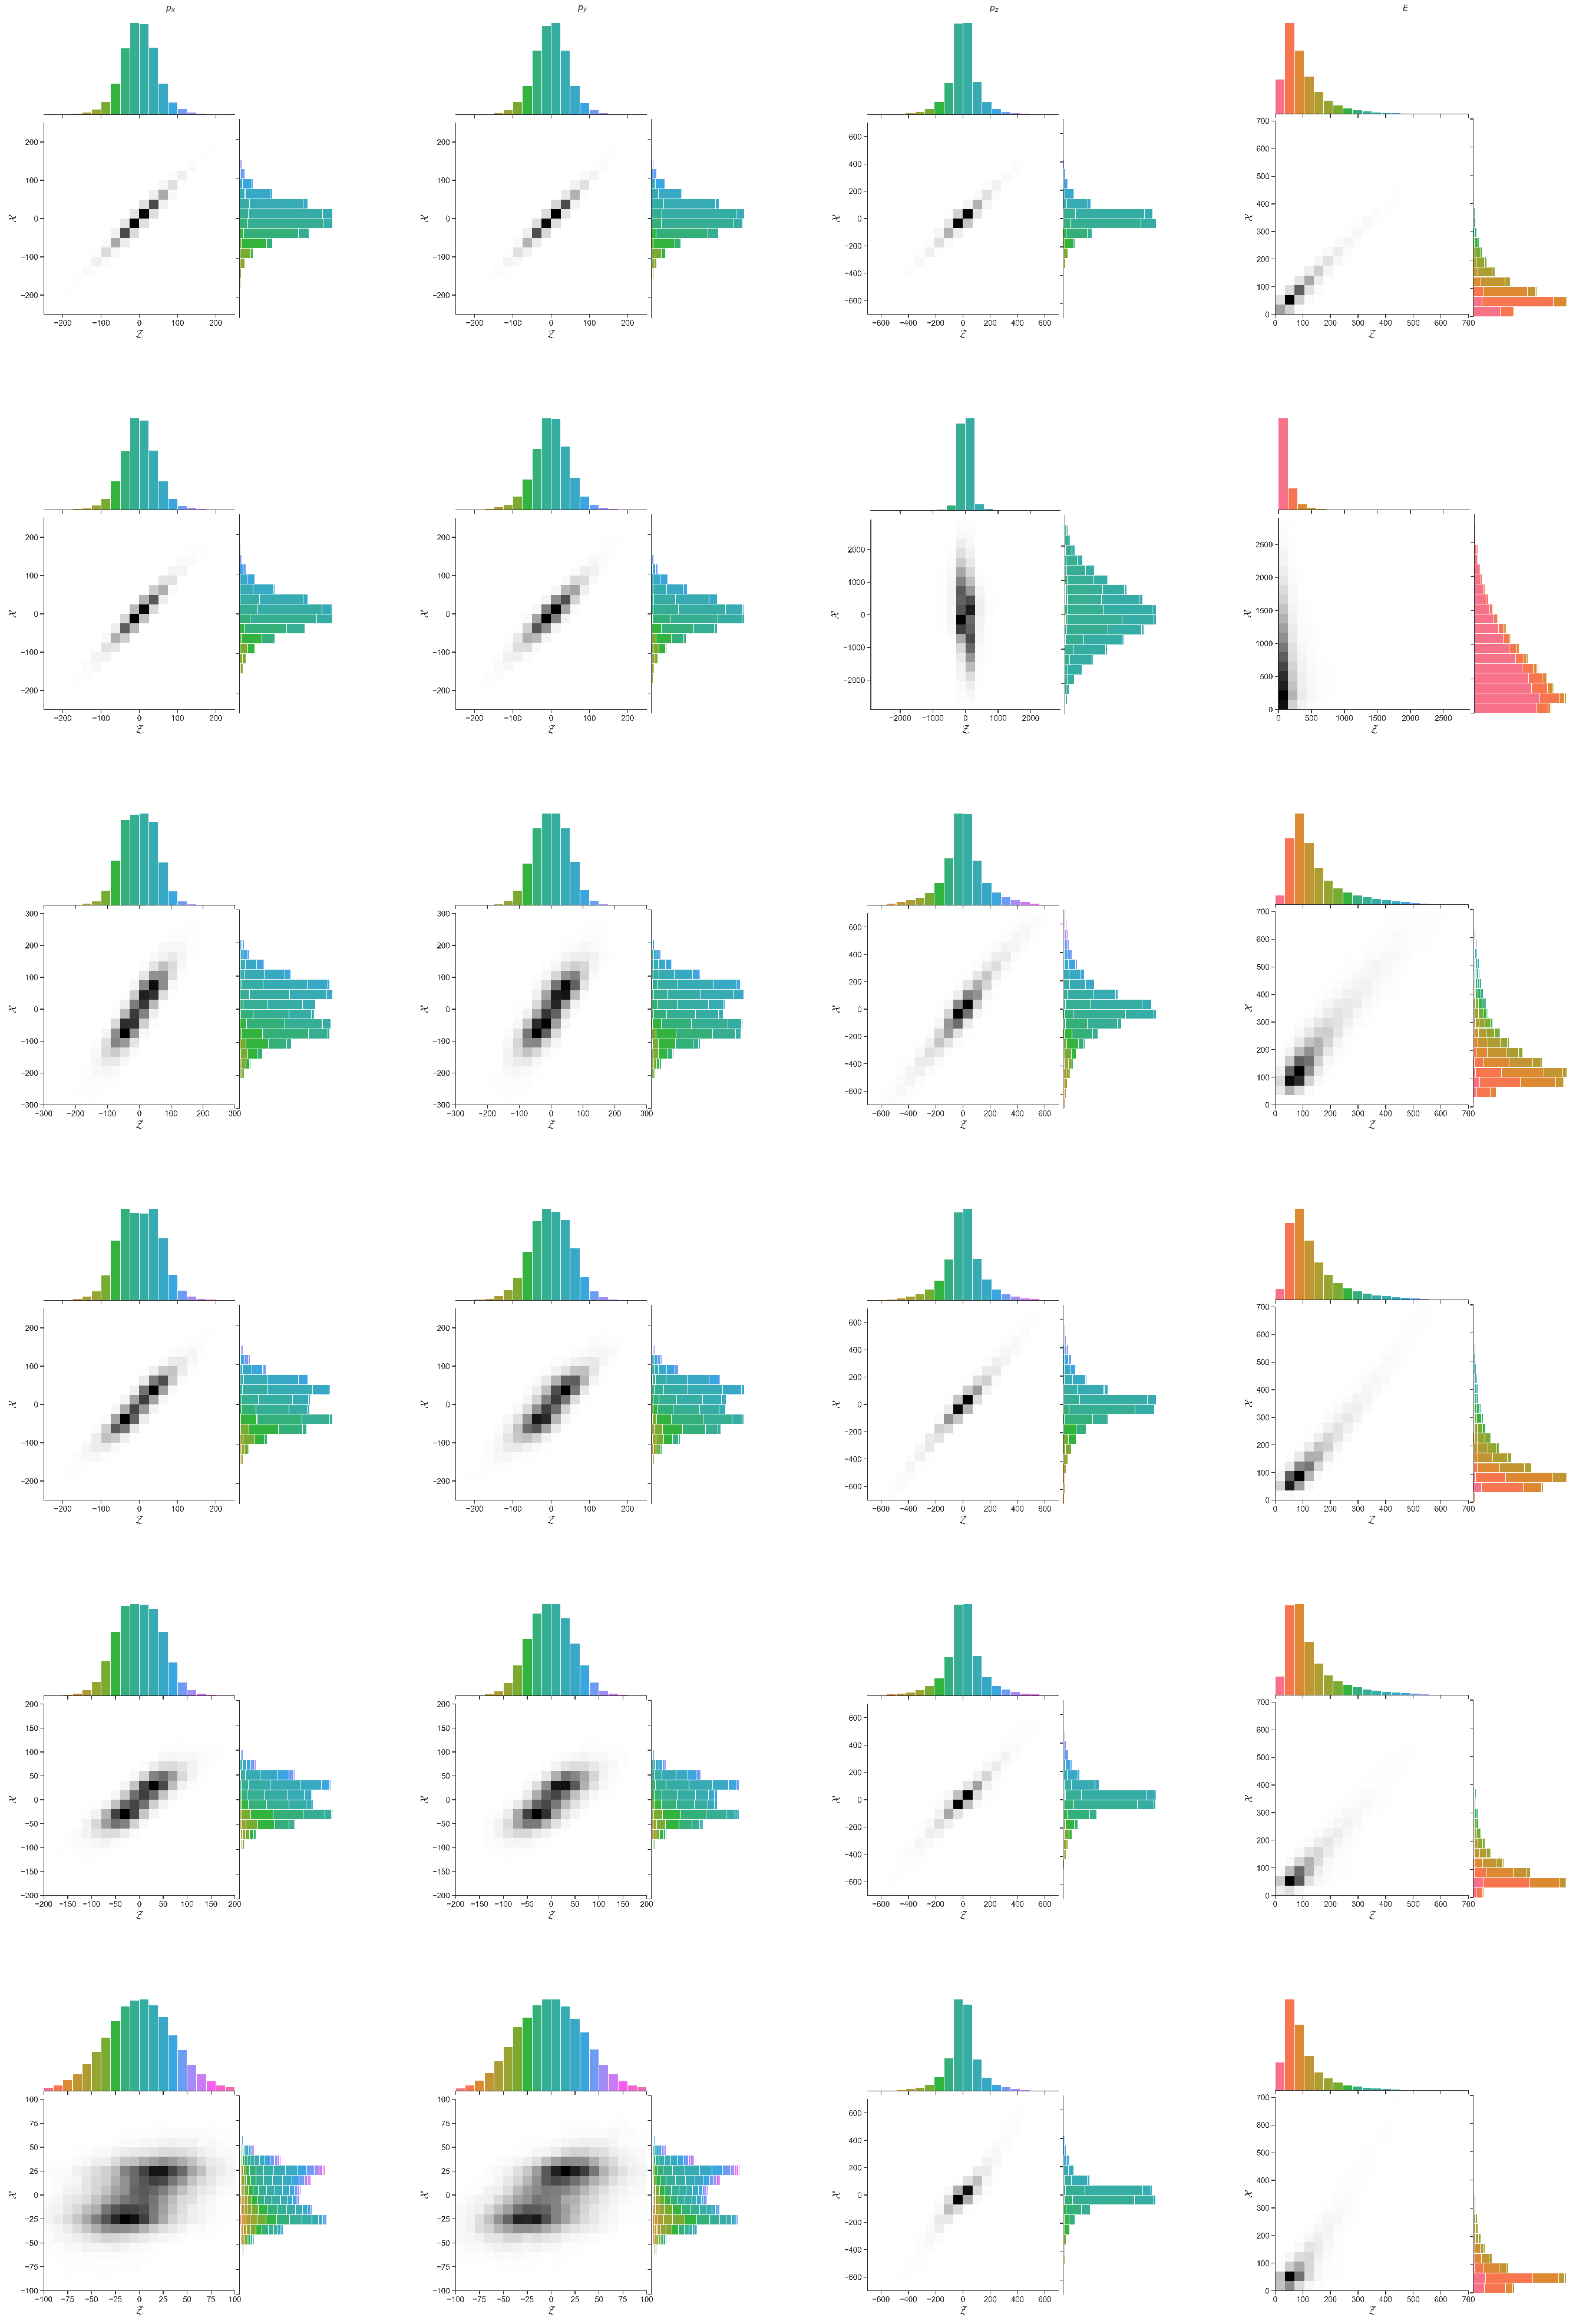

In [45]:
fullTransportPlot(arrs['x_encoded_'], arrs['x_reconstructed_'], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

#### Transport plans for true mapping $z$ -> $x$ (now on training data)

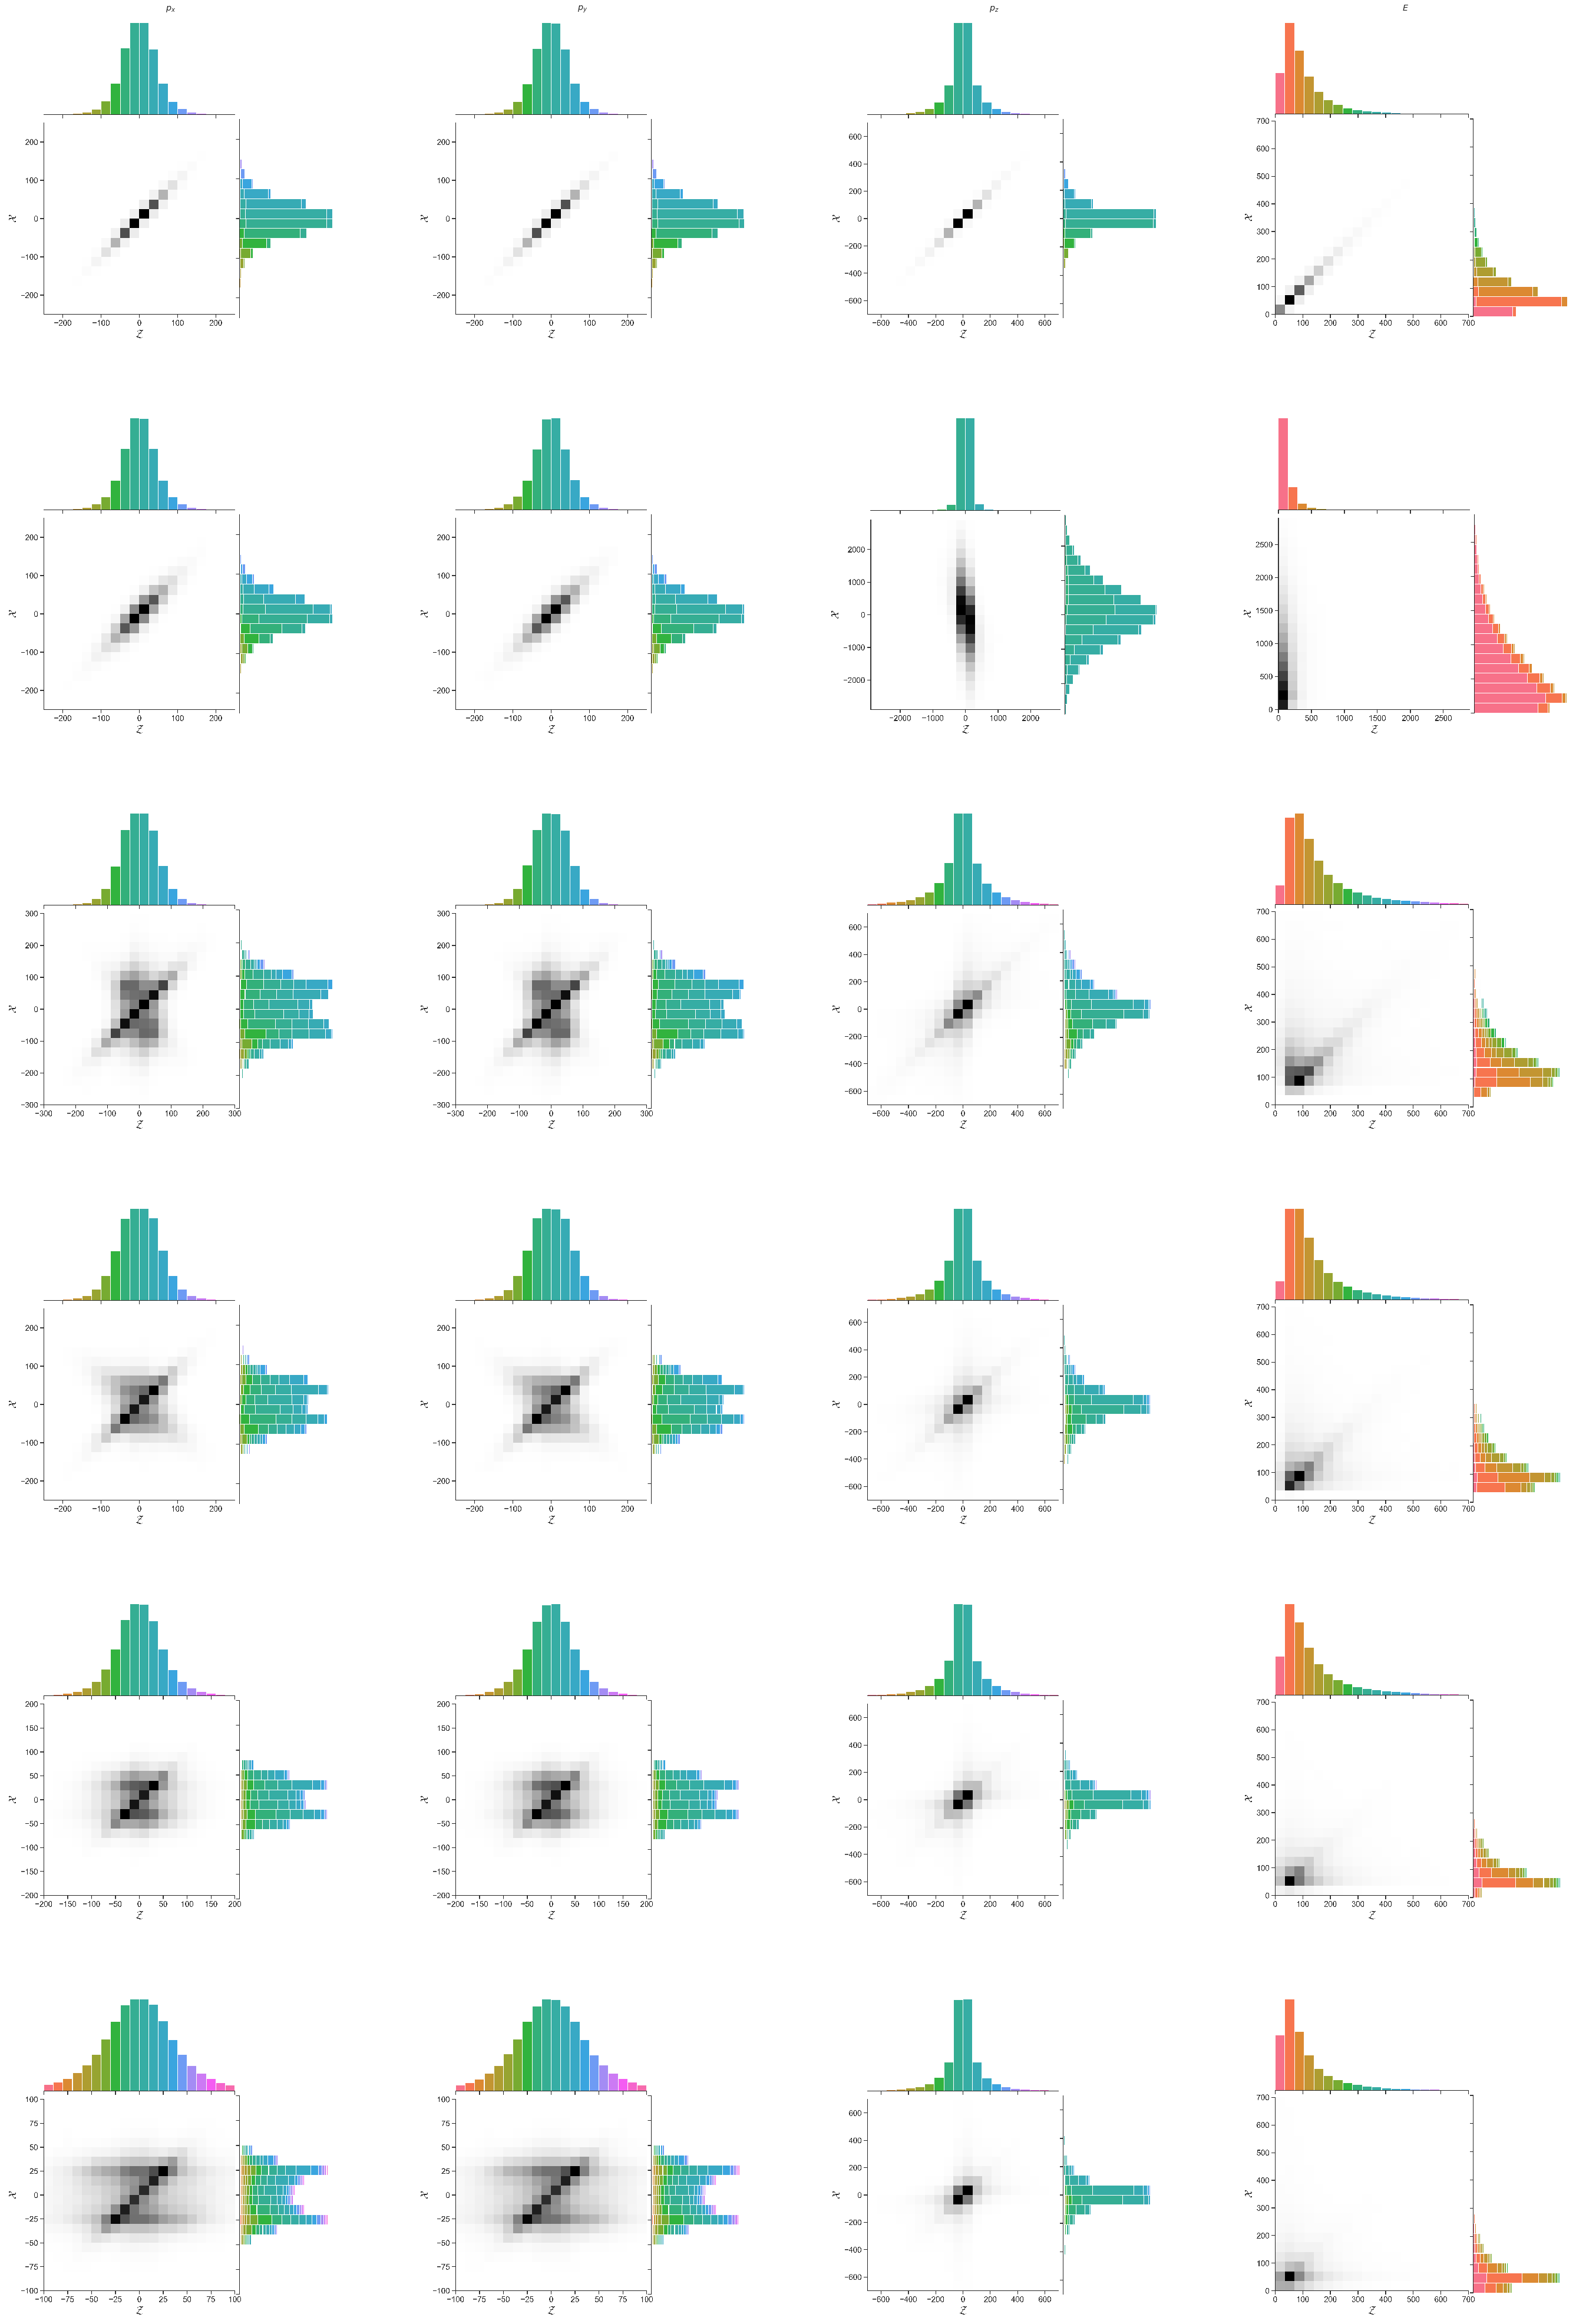

In [46]:
arrs = all_arrs['train']
fullTransportPlot(arrs['z'], arrs['x'], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

# Save Trained Model

In [47]:
save_path = 'otus-dataset=%s.pkl' %dataset_name
# save_path = 'swae-dataset=%s-lamb=20-joint_epochs=1000-finetuned.pkl' %dataset_name
torch.save(model.state_dict(), save_path)
print('model weights saved at', save_path)

model weights saved at otus-dataset=ppttbar.pkl


# Evaluate Trained Model on Testing Data

For easier downstream analysis we also evaluate the trained model on our testing dataset.

In [48]:
#-- Get testing dataset --#
test_dataset_name = 'ppttbar_test'
test_dataset = get_dataset(test_dataset_name)
test_z_data, test_x_data = test_dataset['z_data'], test_dataset['x_data']

print(test_z_data.shape, test_x_data.shape)

(160000, 24) (160000, 24)


In [49]:
#-- Reset random seeds --#
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

#-- Evaluate trained model on testing dataset --#

# Use CPU instead of GPU
#model.to('cpu')
#model.encoder.output_stats.to('cpu')
#model.decoder.output_stats.to('cpu')

# Convert the whole testing dataset's type and add to all_arrs
all_arrs['test'] = {}
all_arrs['test']['x'] = np.array(test_x_data, dtype=float_type) 
all_arrs['test']['z'] = np.array(test_z_data, dtype=float_type) 
print(all_arrs['test']['x'].shape, all_arrs['test']['z'].shape)

# Evaluate trained model on testing dataset
arrs = all_arrs['test']

arrs['z_decoded'] = model.decode(torch.from_numpy(arrs['z'])) # p_D(x) = \int_z p(z) p_D(x|z)  "x_pred_truth"
arrs['x_encoded'] = model.encode(torch.from_numpy(arrs['x'])) # p_E(z) = \int_x p(x) p_E(z|x)  "z_pred"
arrs['x_reconstructed'] = model.decode(arrs['x_encoded'])     # p_D(y) = \int_x \int_z p(x) p_E(z|x) p_D(y|z) "x_pred"
       
# Feed the same z input to the decoder multiple times and study the stochastic output
num_repeats = 100
num_diff_zs = 100

arrs['z_rep'] = np.array([np.repeat(arrs['z'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)])       # "z_fixed"
z_rep_tensor = torch.from_numpy(arrs['z_rep'])                                                                 # tmp
arrs['z_decoded_rep'] = np.array([model.decode(z_rep_tensor[i]).detach().numpy() for i in range(num_diff_zs)]) # "x_pred_truth_fixed"
arrs['x_rep'] = np.array([np.repeat(arrs['x'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)])       # "x_fixed"

# Convert all results to numpy arrays
for (field, arr) in arrs.items():
    if isinstance(arr, torch.Tensor):
        arrs[field] = arr.detach().numpy()

(160000, 24) (160000, 24)


In [50]:
#-- Create new arrays from model output that passes cuts --#

arrs = all_arrs['test']

for field in ('z_decoded', 'x_reconstructed'):
    arr = arrs[field]
    
    if raw_io:
        arr_raw = arr
    else:
        arr_raw = (arr * x_train_std) + x_train_mean
    
    # Keep only events that pass threshold constraint
    good_mask = threshold_check(arr_raw)
    print('passing rate of', field, good_mask.mean())
    arr_raw = arr_raw[good_mask]  # only keep the ones that passed tests
    
    if raw_io:
        arr = arr_raw
    else:
        arr = (arr_raw - x_train_mean) / x_train_std
    
    arrs[field+'_'] = arr

    # Store masks that determine event-by-event passing
    arrs[field+'_good_mask'] = good_mask

# Print all keys in 'test' category
print(arrs.keys())

passing rate of z_decoded 0.598125
passing rate of x_reconstructed 0.89654375
dict_keys(['x', 'z', 'z_decoded', 'x_encoded', 'x_reconstructed', 'z_rep', 'z_decoded_rep', 'x_rep', 'z_decoded_', 'z_decoded_good_mask', 'x_reconstructed_', 'x_reconstructed_good_mask'])


## Save trimmed version of testing data model results

We trim the results of running the trained model on testing data. This is to save on storage space. All deleted arrays can be derived from the other stored arrays and/or initial datasets.

In [51]:
for extra_key in ('x', 'z', 'z_rep', 'z_decoded_rep', 'x_rep'):
    del arrs[extra_key]

for key in list(arrs.keys()):
    if key.endswith('_'):
        del arrs[key]
print(arrs.keys())

dict_keys(['z_decoded', 'x_encoded', 'x_reconstructed', 'z_decoded_good_mask', 'x_reconstructed_good_mask'])


In [52]:
save_path = 'otus_results-dataset=%s.npz' %test_dataset_name
np.savez(save_path, **all_arrs['test'])
print('Model results saved at', save_path)

Model results saved at otus_results-dataset=ppttbar_test.npz
